# Bài tập cuối kỳ môn Machine Learning: Giá thành của 1 laptop dựa trên cấu hình của máy và nhà sản xuất

## Thư viện

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

## Define các hàm để in ra sự so sánh (nếu có)

In [3]:
def compare_metrics(metrics, ylabel, title):
    model_names = list(metrics.keys())

    # Create an array to store the number of models
    models = np.arange(len(model_names))

    metrics_values = [np.mean(metrics[model]) for model in model_names]

    # Set the width of the bars
    bar_width = 0.4
    opacity = 0.8

    # Calculate the spacing between each model
    model_spacing = 0.5

    # Calculate the total width for each model including the spacing
    total_width = bar_width + model_spacing

    # Calculate the starting positions for each model
    index = np.arange(len(models)) * total_width

    plt.bar(index, metrics_values, bar_width, alpha=opacity)

    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(index, model_names)
    plt.legend()

    plt.tight_layout()
    plt.show()

def print_metrics(mse, mae, r2):
    print("MSE scores:", mse)
    print("Mean MSE score:", mse.mean())
    print("MAE scores:", mae)
    print("Mean MAE score:", mae.mean())
    print("R2 scores:", r2)
    print("Mean R2 score:", r2.mean())

def plot_training_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## Phần 1 + Phần 4: Data Exploration + Data Preprocessing

### Data cleaning

In [4]:
df = pd.DataFrame(pd.read_csv('laptopData.csv'))
df.drop('ID', axis=1, inplace=True)
df

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080
...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,33992.6400
1299,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,79866.7200
1300,Lenovo,Notebook,14,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,12201.1200
1301,HP,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,40705.9200


In [56]:
df.describe()

,Company,TypeName,Inches,Ram,Price,ScreenType,Resolution,CPU_Company,CPU_Type,CPU_Freq,Memory1,Memory2,GPU_Company,OS_Name
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000
mean,6.457395,2.584405,13.047428,6.549839,60606.281350,5.089228,4.069132,0.952572,50.277331,19.551447,11.594855,5.213023,2.038585,4.590836
std,4.115464,1.246762,3.699732,2.966955,37424.654634,5.092633,3.104256,0.216388,17.027339,5.765581,4.849779,1.798039,0.927001,1.228102
min,0.000000,0.000000,0.000000,0.000000,9271.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,11.000000,6.000000,32655.750000,3.000000,4.000000,1.000000,41.000000,14.000000,8.000000,6.000000,2.000000,5.000000
50%,7.000000,3.000000,15.000000,8.000000,52694.000000,3.000000,4.000000,1.000000,52.000000,21.000000,12.000000,6.000000,2.000000,5.000000
75%,10.000000,3.000000,15.000000,9.000000,79813.000000,10.000000,4.000000,1.000000,62.000000,23.000000,14.000000,6.000000,3.000000,5.000000
max,18.000000,5.000000,24.000000,9.000000,324955.000000,24.000000,15.000000,2.000000,92.000000,31.000000,24.000000,6.000000,3.000000,6.000000


In [5]:
df.size

14333

In [6]:
df.isna().sum()

Company             30
TypeName            30
Inches              30
ScreenResolution    30
Cpu                 30
Ram                 30
Memory              30
Gpu                 30
OpSys               30
Weight              30
Price               30
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.duplicated().sum()

29

In [9]:
df.drop_duplicates(inplace=True)

### Data handling Categorical

#### Kiểm tra các unique

In [10]:
df['Company'].unique()


array(['Apple', 'HP', 'Acer', 'Asus', 'Dell', 'Lenovo', 'Chuwi', 'MSI',
       'Microsoft', 'Toshiba', 'Huawei', 'Xiaomi', 'Vero', 'Razer',
       'Mediacom', 'Samsung', 'Google', 'Fujitsu', 'LG'], dtype=object)

In [11]:
df['TypeName'].unique()

array(['Ultrabook', 'Notebook', 'Gaming', '2 in 1 Convertible',
       'Workstation', 'Netbook'], dtype=object)

In [12]:
df['Inches'].unique()

array(['13.3', '15.6', '15.4', '14', '12', '17.3', '13.5', '12.5', '13',
       '18.4', '13.9', '11.6', '25.6', '35.6', '12.3', '27.3', '24',
       '33.5', '?', '31.6', '17', '15', '14.1', '11.3', '10.1'],
      dtype=object)

In [13]:
df['Ram'].unique()

array(['8GB', '16GB', '4GB', '2GB', '12GB', '64GB', '6GB', '32GB', '24GB',
       '1GB'], dtype=object)

In [14]:
df['Memory'].unique()

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '128GB SSD +  1TB HDD', '256GB SSD +  256GB SSD',
       '64GB Flash Storage', '32GB Flash Storage', '256GB SSD +  1TB HDD',
       '256GB SSD +  2TB HDD', '32GB SSD', '2TB HDD', '64GB SSD',
       '1.0TB Hybrid', '512GB SSD +  1TB HDD', '1TB SSD',
       '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '?', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

In [15]:
df['Gpu'].unique()

array(['Intel Iris Plus Graphics 640', 'Intel HD Graphics 6000',
       'Intel HD Graphics 620', 'AMD Radeon Pro 455',
       'Intel Iris Plus Graphics 650', 'AMD Radeon R5',
       'Intel Iris Pro Graphics', 'Nvidia GeForce MX150',
       'Intel UHD Graphics 620', 'Intel HD Graphics 520',
       'AMD Radeon Pro 555', 'AMD Radeon R5 M430',
       'Intel HD Graphics 615', 'AMD Radeon Pro 560',
       'Nvidia GeForce 940MX', 'Nvidia GeForce GTX 1050', 'AMD Radeon R2',
       'AMD Radeon 530', 'Nvidia GeForce 930MX', 'Intel HD Graphics',
       'Intel HD Graphics 500', 'Nvidia GeForce 930MX ',
       'Nvidia GeForce GTX 1060', 'Nvidia GeForce 150MX',
       'Intel Iris Graphics 540', 'AMD Radeon RX 580',
       'Nvidia GeForce 920MX', 'AMD Radeon R4 Graphics', 'AMD Radeon 520',
       'Nvidia GeForce GTX 1070', 'Nvidia GeForce GTX 1050 Ti',
       'Intel HD Graphics 400', 'Nvidia GeForce MX130', 'AMD R4 Graphics',
       'Nvidia GeForce GTX 940MX', 'AMD Radeon RX 560',
       'Nvidia GeFo

In [16]:
df['OpSys'].unique()

array(['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux',
       'Windows 10 S', 'Chrome OS', 'Windows 7', 'Android'], dtype=object)

#### Có thể thấy rằng Dataset này có vài Feature có giá trị chứa 2 dữ liệu có thể ảnh hưởng đến Giá thành, cho nên ở đây em sẽ bắt đầu tách các dữ liệu cần thiết.

In [17]:
df.dtypes

Company              object
TypeName             object
Inches               object
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price               float64
dtype: object

In [18]:
# Đầu tiên là với Screen Resolution bao gồm loại màn và độ phân giải.

df['ScreenType'] = df['ScreenResolution'].apply(lambda x: (str(x))[:-9])
df['Resolution'] = df['ScreenResolution'].apply(lambda x: (str(x))[-9:])
df.drop('ScreenResolution', inplace=True, axis=1)
df

,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,ScreenType,Resolution
0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832,IPS Panel Retina Display,2560x1600
1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232,,1440x900
2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000,Full HD,1920x1080
3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360,IPS Panel Retina Display,2880x1800
4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080,IPS Panel Retina Display,2560x1600
...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Asus,Notebook,15.6,Intel Core i7 6500U 2.5GHz,4GB,500GB HDD,Nvidia GeForce 920M,Windows 10,2.2kg,38378.6496,,1366x768
1270,Lenovo,2 in 1 Convertible,14,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,33992.6400,IPS Panel Full HD / Touchscreen,1920x1080
1271,Lenovo,2 in 1 Convertible,13.3,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,79866.7200,IPS Panel Quad HD+ / Touchscreen,3200x1800
1272,Lenovo,Notebook,14,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,12201.1200,,1366x768


In [19]:
# Tiếp đến là CPU, có thể thấy là CPU gồm 3 yếu tố ảnh hưởng đến giá là công ty CPU, loại CPU và xung nhịp

df['Cpu'].astype(str)
df['CPU_Company'] = df['Cpu'].str.split(" ").apply(lambda x: x[0])
df['CPU_Type'] = df['Cpu'].str.split(" ").apply(lambda x: x[1:-1]).str.join(sep=" ")
df['CPU_Freq'] = df['Cpu'].apply(lambda x: (str(x))[-6:])
df.drop('Cpu', inplace=True, axis=1)
df

,Company,TypeName,Inches,Ram,Memory,Gpu,OpSys,Weight,Price,ScreenType,Resolution,CPU_Company,CPU_Type,CPU_Freq
0,Apple,Ultrabook,13.3,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832,IPS Panel Retina Display,2560x1600,Intel,Core i5,2.3GHz
1,Apple,Ultrabook,13.3,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232,,1440x900,Intel,Core i5,1.8GHz
2,HP,Notebook,15.6,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000,Full HD,1920x1080,Intel,Core i5 7200U,2.5GHz
3,Apple,Ultrabook,15.4,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360,IPS Panel Retina Display,2880x1800,Intel,Core i7,2.7GHz
4,Apple,Ultrabook,13.3,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080,IPS Panel Retina Display,2560x1600,Intel,Core i5,3.1GHz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Asus,Notebook,15.6,4GB,500GB HDD,Nvidia GeForce 920M,Windows 10,2.2kg,38378.6496,,1366x768,Intel,Core i7 6500U,2.5GHz
1270,Lenovo,2 in 1 Convertible,14,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,33992.6400,IPS Panel Full HD / Touchscreen,1920x1080,Intel,Core i7 6500U,2.5GHz
1271,Lenovo,2 in 1 Convertible,13.3,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,79866.7200,IPS Panel Quad HD+ / Touchscreen,3200x1800,Intel,Core i7 6500U,2.5GHz
1272,Lenovo,Notebook,14,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,12201.1200,,1366x768,Intel,Celeron Dual Core N3050,1.6GHz


In [20]:
# Với phần Ổ cứng, có thể thấy rằng một số máy có thể được trang bị 2 ổ cứng

df['Memory'] = df['Memory'].astype(str)
df['Memory1'] = df['Memory'].str.split(r'\s*\+\s*').str.get(0)
df['Memory2'] = df['Memory'].str.split(r'\s*\+\s*').str.get(1)

df.drop('Memory', axis=1, inplace=True)
df.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price,ScreenType,Resolution,CPU_Company,CPU_Type,CPU_Freq,Memory1,Memory2
0,Apple,Ultrabook,13.3,8GB,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832,IPS Panel Retina Display,2560x1600,Intel,Core i5,2.3GHz,128GB SSD,NaN
1,Apple,Ultrabook,13.3,8GB,Intel HD Graphics 6000,macOS,1.34kg,47895.5232,,1440x900,Intel,Core i5,1.8GHz,128GB Flash Storage,NaN
2,HP,Notebook,15.6,8GB,Intel HD Graphics 620,No OS,1.86kg,30636.0000,Full HD,1920x1080,Intel,Core i5 7200U,2.5GHz,256GB SSD,NaN
3,Apple,Ultrabook,15.4,16GB,AMD Radeon Pro 455,macOS,1.83kg,135195.3360,IPS Panel Retina Display,2880x1800,Intel,Core i7,2.7GHz,512GB SSD,NaN
4,Apple,Ultrabook,13.3,8GB,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080,IPS Panel Retina Display,2560x1600,Intel,Core i5,3.1GHz,256GB SSD,NaN


In [21]:
# Phần GPU - Card đồ họa có thể tách ra công ty card cùng với loại card của công ty đó

df['GPU_Company'] = df['Gpu'].apply(lambda x: x.split(" ",1)[0])
df['GPU_Name'] = df['Gpu'].apply(lambda x: x.split(" ",1)[1])
df.drop('Gpu', inplace=True, axis=1)
df

,Company,TypeName,Inches,Ram,OpSys,Weight,Price,ScreenType,Resolution,CPU_Company,CPU_Type,CPU_Freq,Memory1,Memory2,GPU_Company,GPU_Name
0,Apple,Ultrabook,13.3,8GB,macOS,1.37kg,71378.6832,IPS Panel Retina Display,2560x1600,Intel,Core i5,2.3GHz,128GB SSD,NaN,Intel,Iris Plus Graphics 640
1,Apple,Ultrabook,13.3,8GB,macOS,1.34kg,47895.5232,,1440x900,Intel,Core i5,1.8GHz,128GB Flash Storage,NaN,Intel,HD Graphics 6000
2,HP,Notebook,15.6,8GB,No OS,1.86kg,30636.0000,Full HD,1920x1080,Intel,Core i5 7200U,2.5GHz,256GB SSD,NaN,Intel,HD Graphics 620
3,Apple,Ultrabook,15.4,16GB,macOS,1.83kg,135195.3360,IPS Panel Retina Display,2880x1800,Intel,Core i7,2.7GHz,512GB SSD,NaN,AMD,Radeon Pro 455
4,Apple,Ultrabook,13.3,8GB,macOS,1.37kg,96095.8080,IPS Panel Retina Display,2560x1600,Intel,Core i5,3.1GHz,256GB SSD,NaN,Intel,Iris Plus Graphics 650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Asus,Notebook,15.6,4GB,Windows 10,2.2kg,38378.6496,,1366x768,Intel,Core i7 6500U,2.5GHz,500GB HDD,NaN,Nvidia,GeForce 920M
1270,Lenovo,2 in 1 Convertible,14,4GB,Windows 10,1.8kg,33992.6400,IPS Panel Full HD / Touchscreen,1920x1080,Intel,Core i7 6500U,2.5GHz,128GB SSD,NaN,Intel,HD Graphics 520
1271,Lenovo,2 in 1 Convertible,13.3,16GB,Windows 10,1.3kg,79866.7200,IPS Panel Quad HD+ / Touchscreen,3200x1800,Intel,Core i7 6500U,2.5GHz,512GB SSD,NaN,Intel,HD Graphics 520
1272,Lenovo,Notebook,14,2GB,Windows 10,1.5kg,12201.1200,,1366x768,Intel,Celeron Dual Core N3050,1.6GHz,64GB Flash Storage,NaN,Intel,HD Graphics


In [22]:
# Hệ điều hành của máy có thể tách ra thành window và mac, tuy nhiên với phần phiên bản của hệ điều hành cần phải cập nhật bởi các ký tự cách nhau.

df['OpSys'] = df['OpSys'].str.replace('No OS', '', regex=1)
df['OpSys'] = df['OpSys'].str.replace('OS X', 'OSX', regex=1)
df['OpSys'] = df['OpSys'].str.replace('10 S', '10S', regex=1)
df['OpSys'] = df['OpSys'].str.replace('Chrome OS', 'ChromeOS', regex=1)

df['OpSys'].unique()

array(['macOS', '', 'Windows 10', 'Mac OSX', 'Linux', 'Windows 10S',
       'ChromeOS', 'Windows 7', 'Android'], dtype=object)

In [23]:
df[["OS_Name", "OS_Model"]] = df['OpSys'].str.split(" ", expand=True)
df.drop('OpSys', axis=1, inplace=True)
df

,Company,TypeName,Inches,Ram,Weight,Price,ScreenType,Resolution,CPU_Company,CPU_Type,CPU_Freq,Memory1,Memory2,GPU_Company,GPU_Name,OS_Name,OS_Model
0,Apple,Ultrabook,13.3,8GB,1.37kg,71378.6832,IPS Panel Retina Display,2560x1600,Intel,Core i5,2.3GHz,128GB SSD,NaN,Intel,Iris Plus Graphics 640,macOS,None
1,Apple,Ultrabook,13.3,8GB,1.34kg,47895.5232,,1440x900,Intel,Core i5,1.8GHz,128GB Flash Storage,NaN,Intel,HD Graphics 6000,macOS,None
2,HP,Notebook,15.6,8GB,1.86kg,30636.0000,Full HD,1920x1080,Intel,Core i5 7200U,2.5GHz,256GB SSD,NaN,Intel,HD Graphics 620,,None
3,Apple,Ultrabook,15.4,16GB,1.83kg,135195.3360,IPS Panel Retina Display,2880x1800,Intel,Core i7,2.7GHz,512GB SSD,NaN,AMD,Radeon Pro 455,macOS,None
4,Apple,Ultrabook,13.3,8GB,1.37kg,96095.8080,IPS Panel Retina Display,2560x1600,Intel,Core i5,3.1GHz,256GB SSD,NaN,Intel,Iris Plus Graphics 650,macOS,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Asus,Notebook,15.6,4GB,2.2kg,38378.6496,,1366x768,Intel,Core i7 6500U,2.5GHz,500GB HDD,NaN,Nvidia,GeForce 920M,Windows,10
1270,Lenovo,2 in 1 Convertible,14,4GB,1.8kg,33992.6400,IPS Panel Full HD / Touchscreen,1920x1080,Intel,Core i7 6500U,2.5GHz,128GB SSD,NaN,Intel,HD Graphics 520,Windows,10
1271,Lenovo,2 in 1 Convertible,13.3,16GB,1.3kg,79866.7200,IPS Panel Quad HD+ / Touchscreen,3200x1800,Intel,Core i7 6500U,2.5GHz,512GB SSD,NaN,Intel,HD Graphics 520,Windows,10
1272,Lenovo,Notebook,14,2GB,1.5kg,12201.1200,,1366x768,Intel,Celeron Dual Core N3050,1.6GHz,64GB Flash Storage,NaN,Intel,HD Graphics,Windows,10


In [24]:
df['Inches'] = df['Inches'].astype(str)
df['Inches'].replace("[^0-9.]","", inplace=True, regex=True)

In [25]:
df['Price'] = df['Price'].round(0)
df

,Company,TypeName,Inches,Ram,Weight,Price,ScreenType,Resolution,CPU_Company,CPU_Type,CPU_Freq,Memory1,Memory2,GPU_Company,GPU_Name,OS_Name,OS_Model
0,Apple,Ultrabook,13.3,8GB,1.37kg,71379.0,IPS Panel Retina Display,2560x1600,Intel,Core i5,2.3GHz,128GB SSD,NaN,Intel,Iris Plus Graphics 640,macOS,None
1,Apple,Ultrabook,13.3,8GB,1.34kg,47896.0,,1440x900,Intel,Core i5,1.8GHz,128GB Flash Storage,NaN,Intel,HD Graphics 6000,macOS,None
2,HP,Notebook,15.6,8GB,1.86kg,30636.0,Full HD,1920x1080,Intel,Core i5 7200U,2.5GHz,256GB SSD,NaN,Intel,HD Graphics 620,,None
3,Apple,Ultrabook,15.4,16GB,1.83kg,135195.0,IPS Panel Retina Display,2880x1800,Intel,Core i7,2.7GHz,512GB SSD,NaN,AMD,Radeon Pro 455,macOS,None
4,Apple,Ultrabook,13.3,8GB,1.37kg,96096.0,IPS Panel Retina Display,2560x1600,Intel,Core i5,3.1GHz,256GB SSD,NaN,Intel,Iris Plus Graphics 650,macOS,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Asus,Notebook,15.6,4GB,2.2kg,38379.0,,1366x768,Intel,Core i7 6500U,2.5GHz,500GB HDD,NaN,Nvidia,GeForce 920M,Windows,10
1270,Lenovo,2 in 1 Convertible,14,4GB,1.8kg,33993.0,IPS Panel Full HD / Touchscreen,1920x1080,Intel,Core i7 6500U,2.5GHz,128GB SSD,NaN,Intel,HD Graphics 520,Windows,10
1271,Lenovo,2 in 1 Convertible,13.3,16GB,1.3kg,79867.0,IPS Panel Quad HD+ / Touchscreen,3200x1800,Intel,Core i7 6500U,2.5GHz,512GB SSD,NaN,Intel,HD Graphics 520,Windows,10
1272,Lenovo,Notebook,14,2GB,1.5kg,12201.0,,1366x768,Intel,Celeron Dual Core N3050,1.6GHz,64GB Flash Storage,NaN,Intel,HD Graphics,Windows,10


### Data Exploration

In [26]:
df.dtypes

Company         object
TypeName        object
Inches          object
Ram             object
Weight          object
Price          float64
ScreenType      object
Resolution      object
CPU_Company     object
CPU_Type        object
CPU_Freq        object
Memory1         object
Memory2         object
GPU_Company     object
GPU_Name        object
OS_Name         object
OS_Model        object
dtype: object

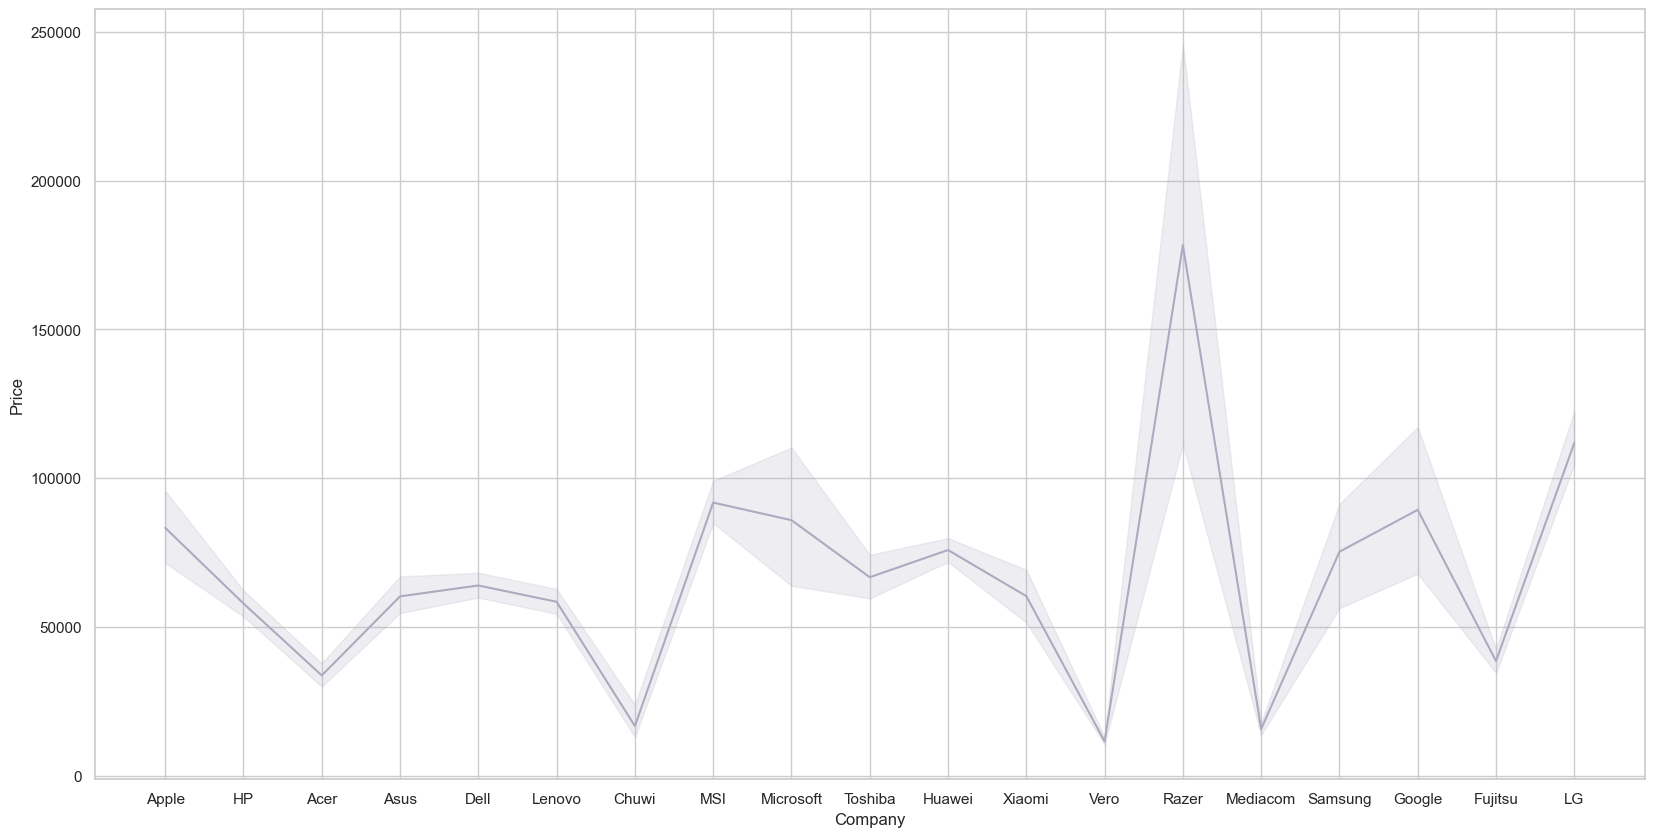

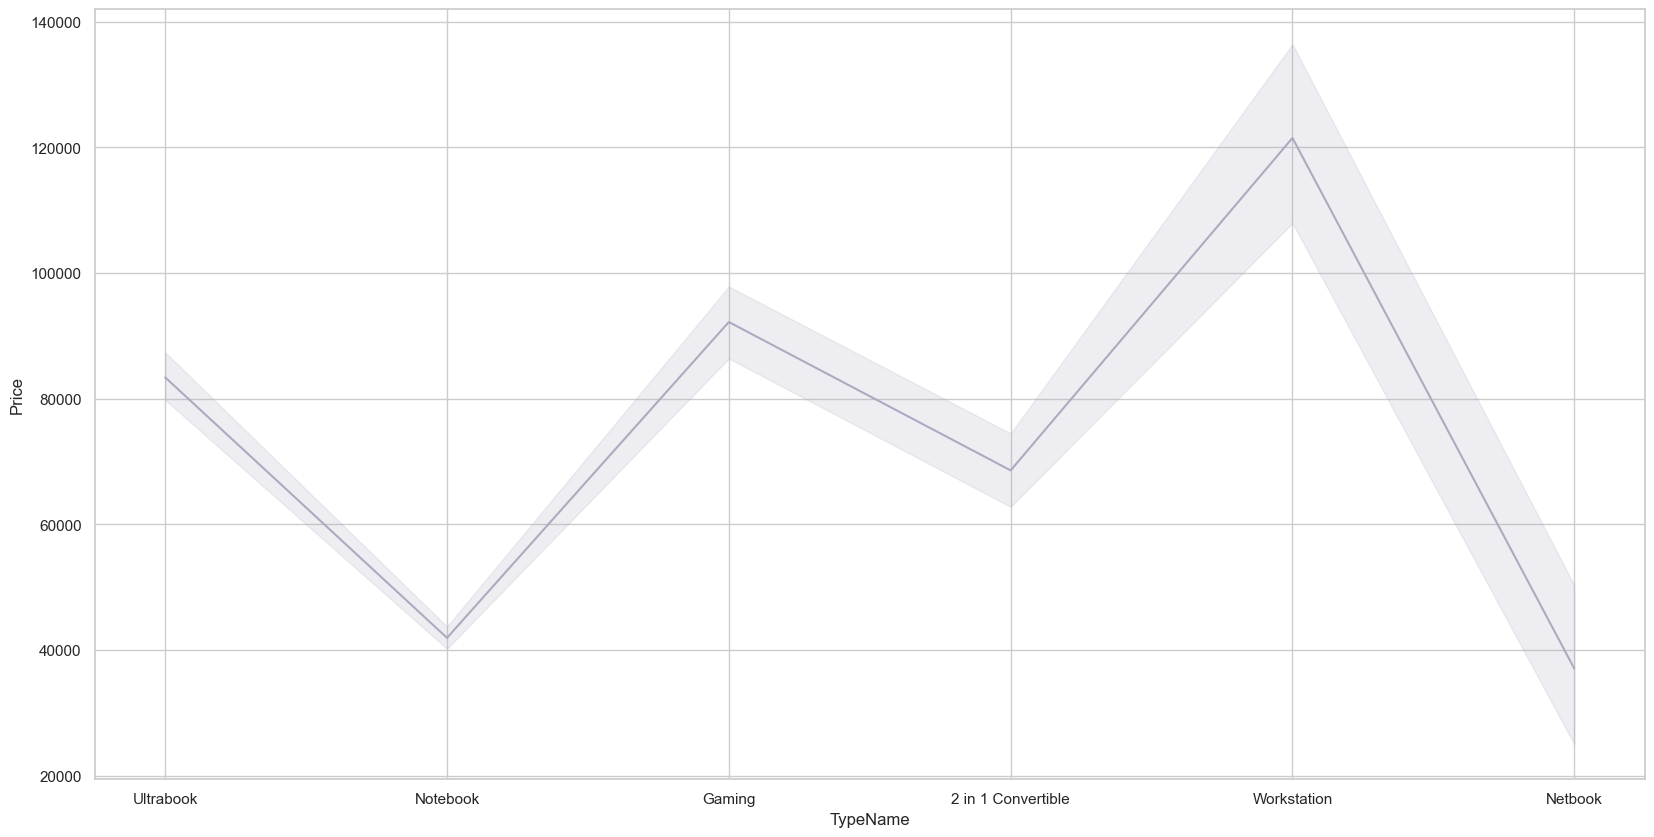

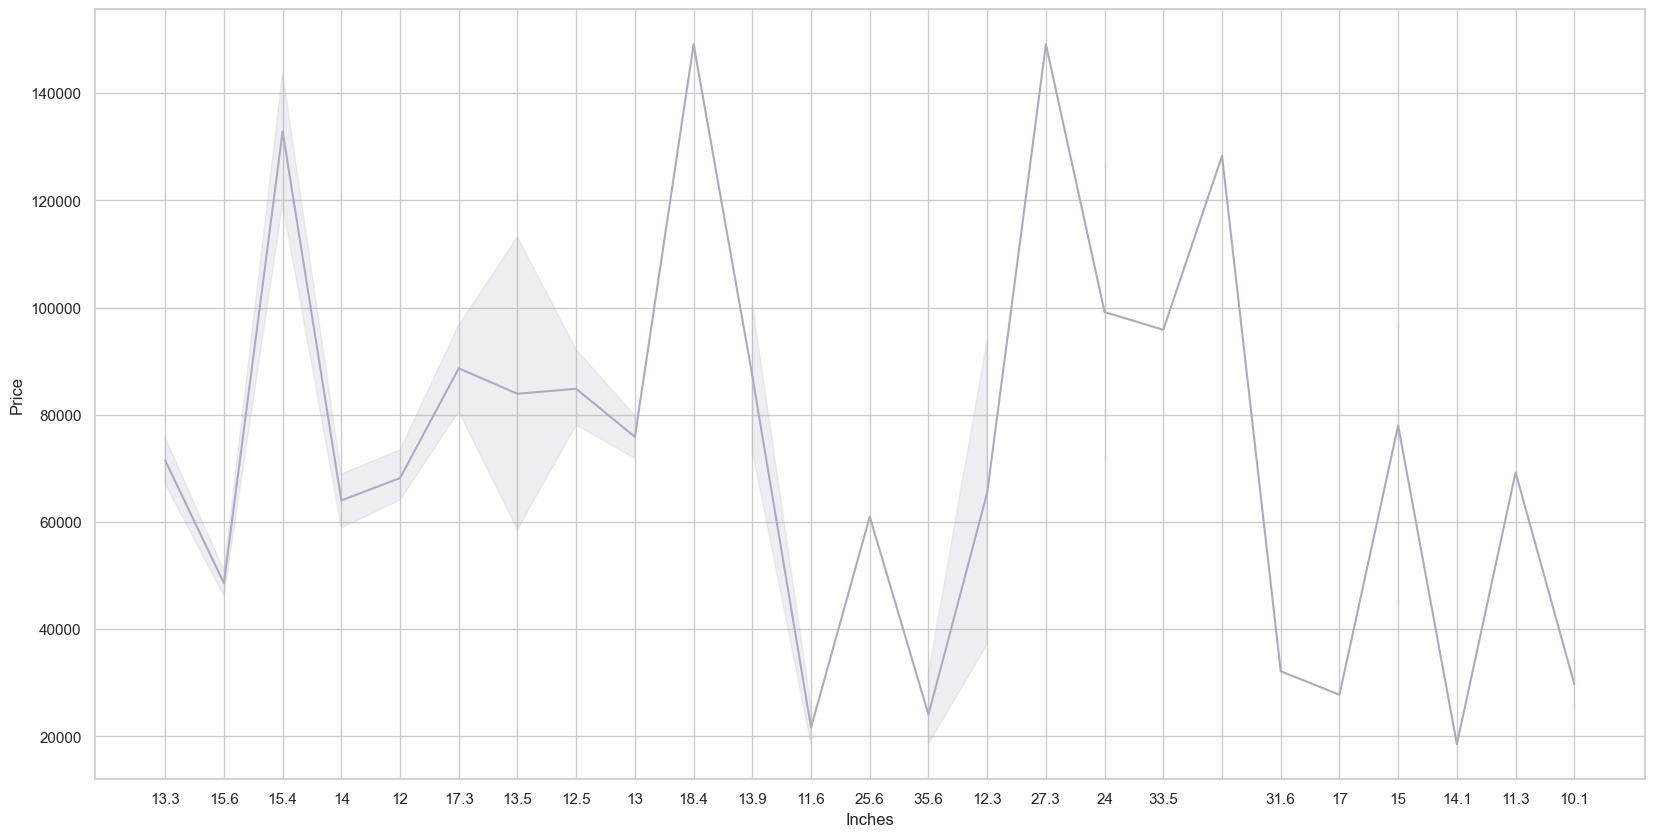

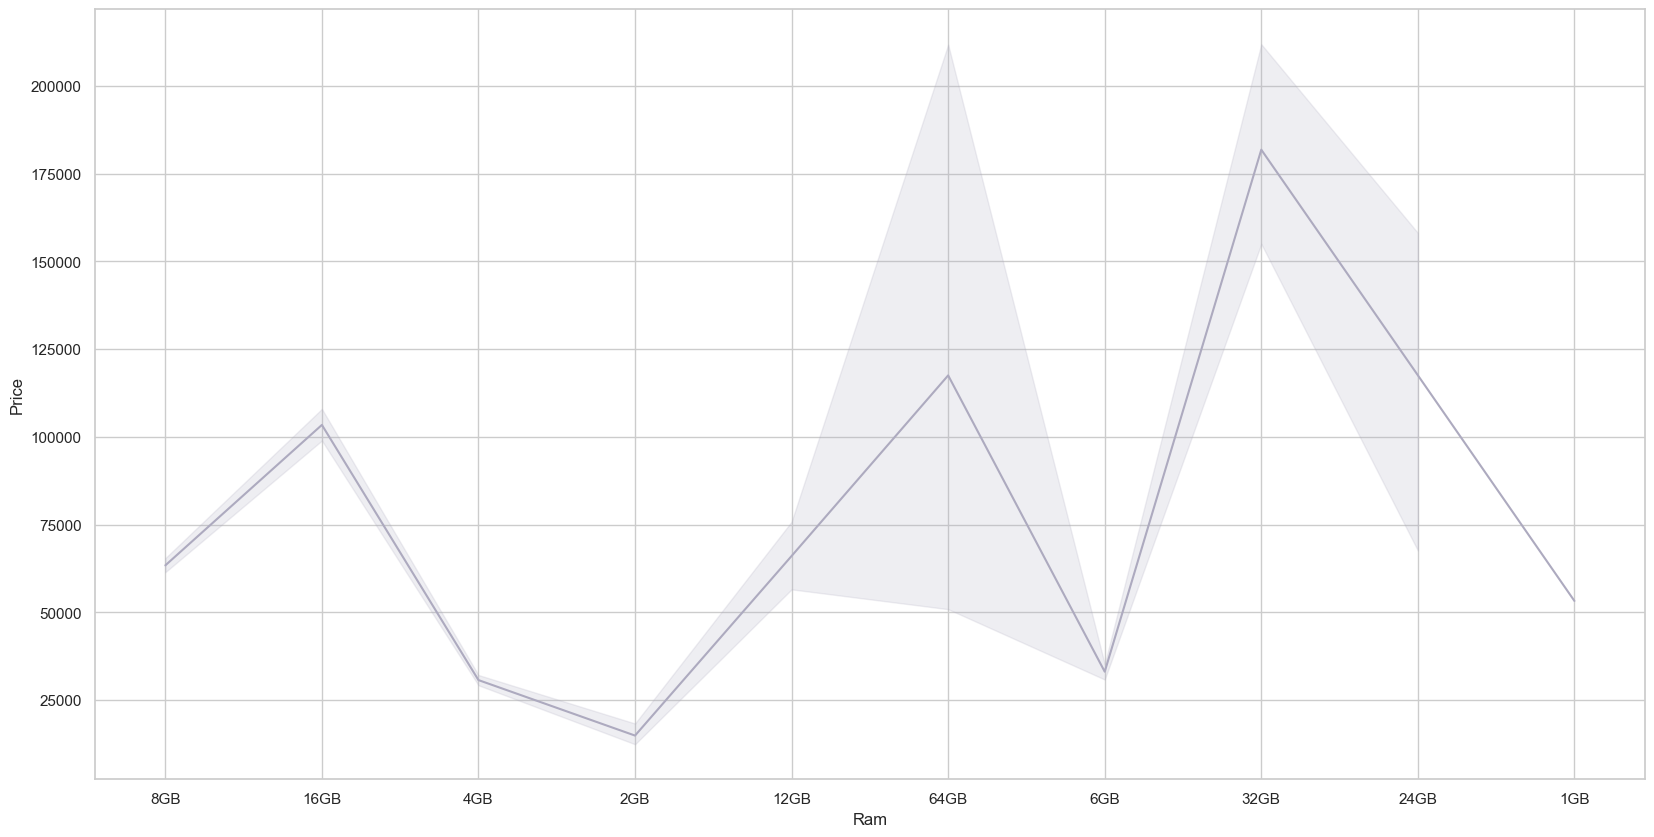

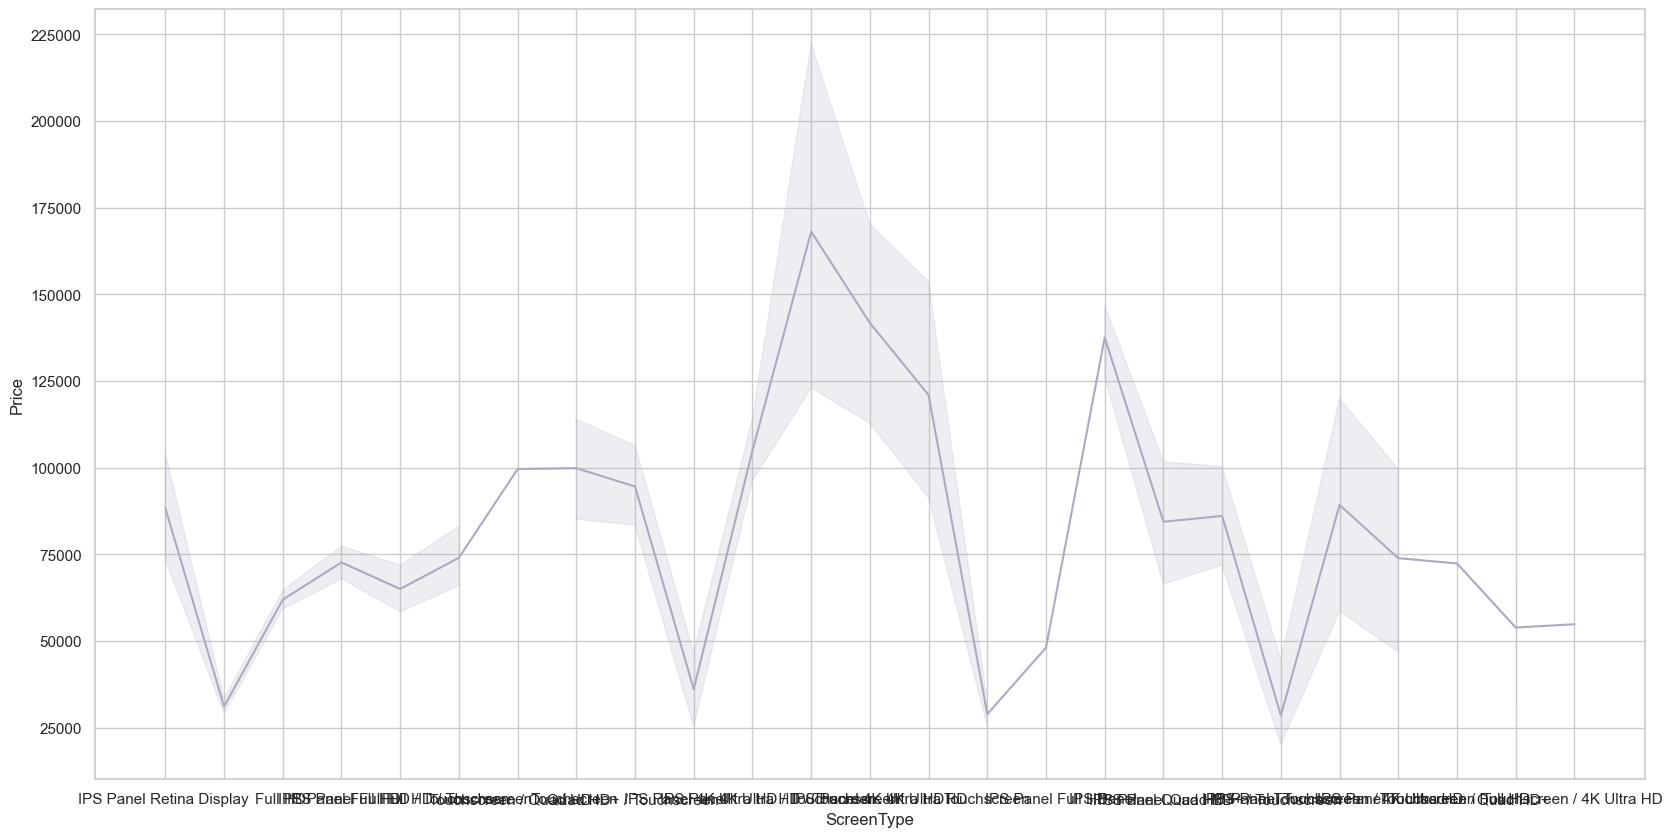

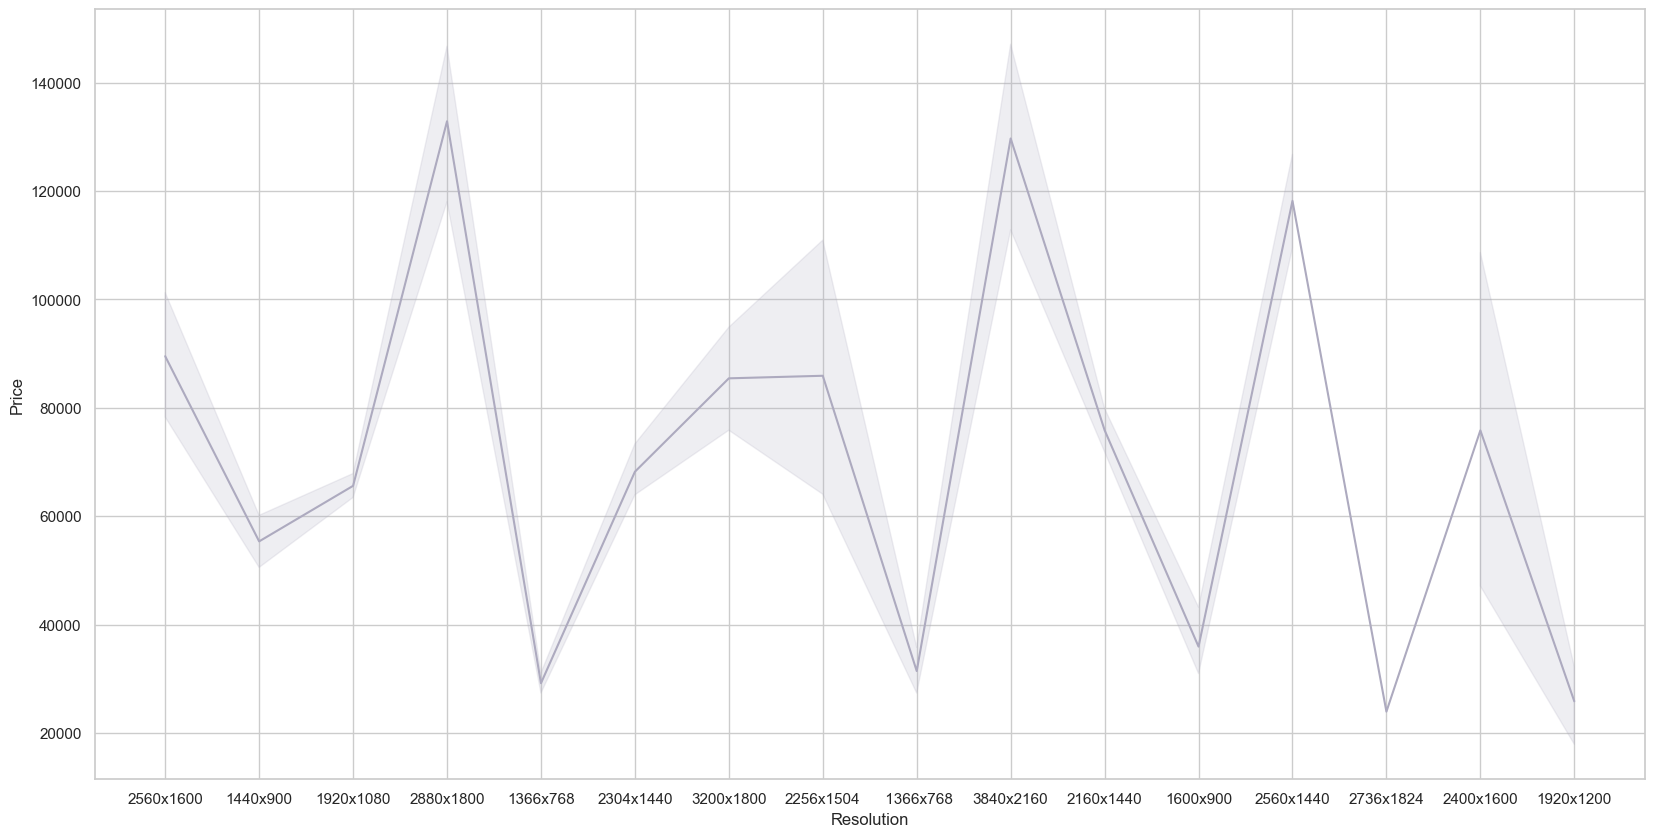

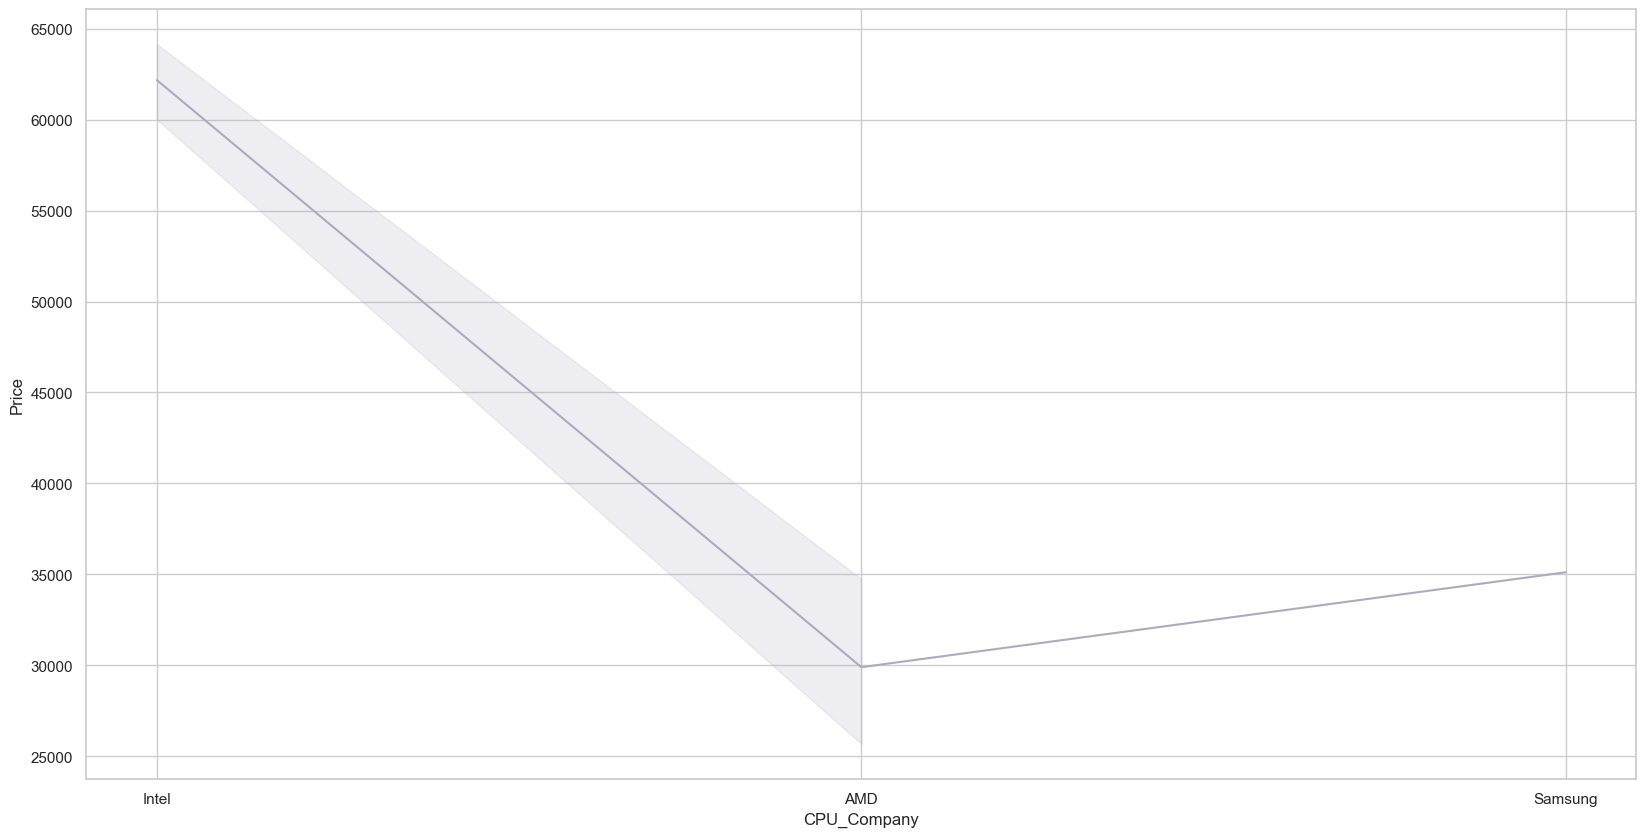

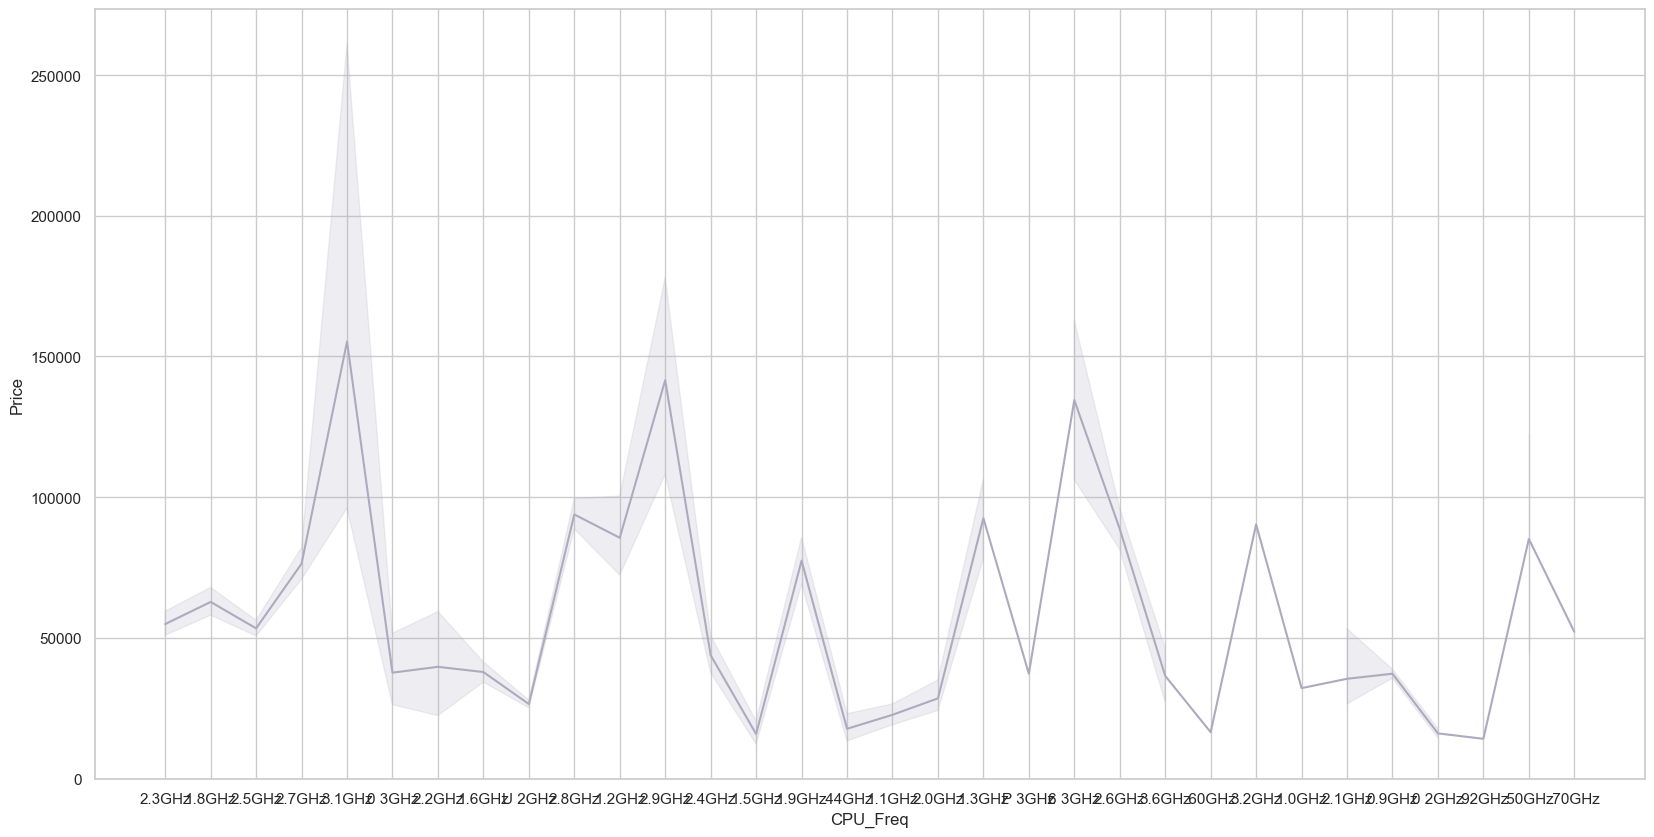

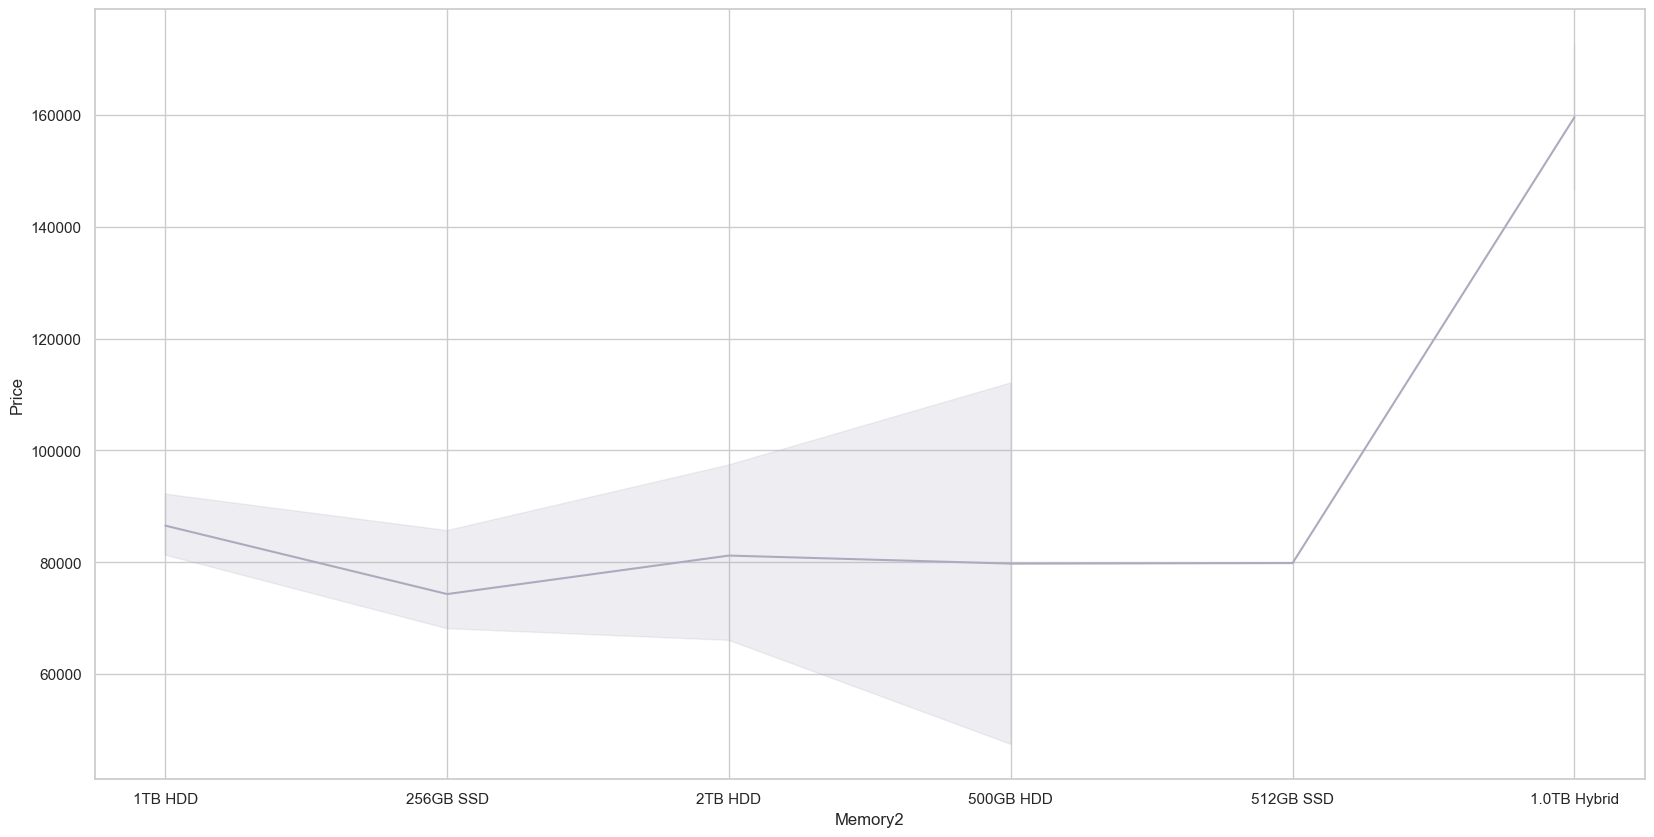

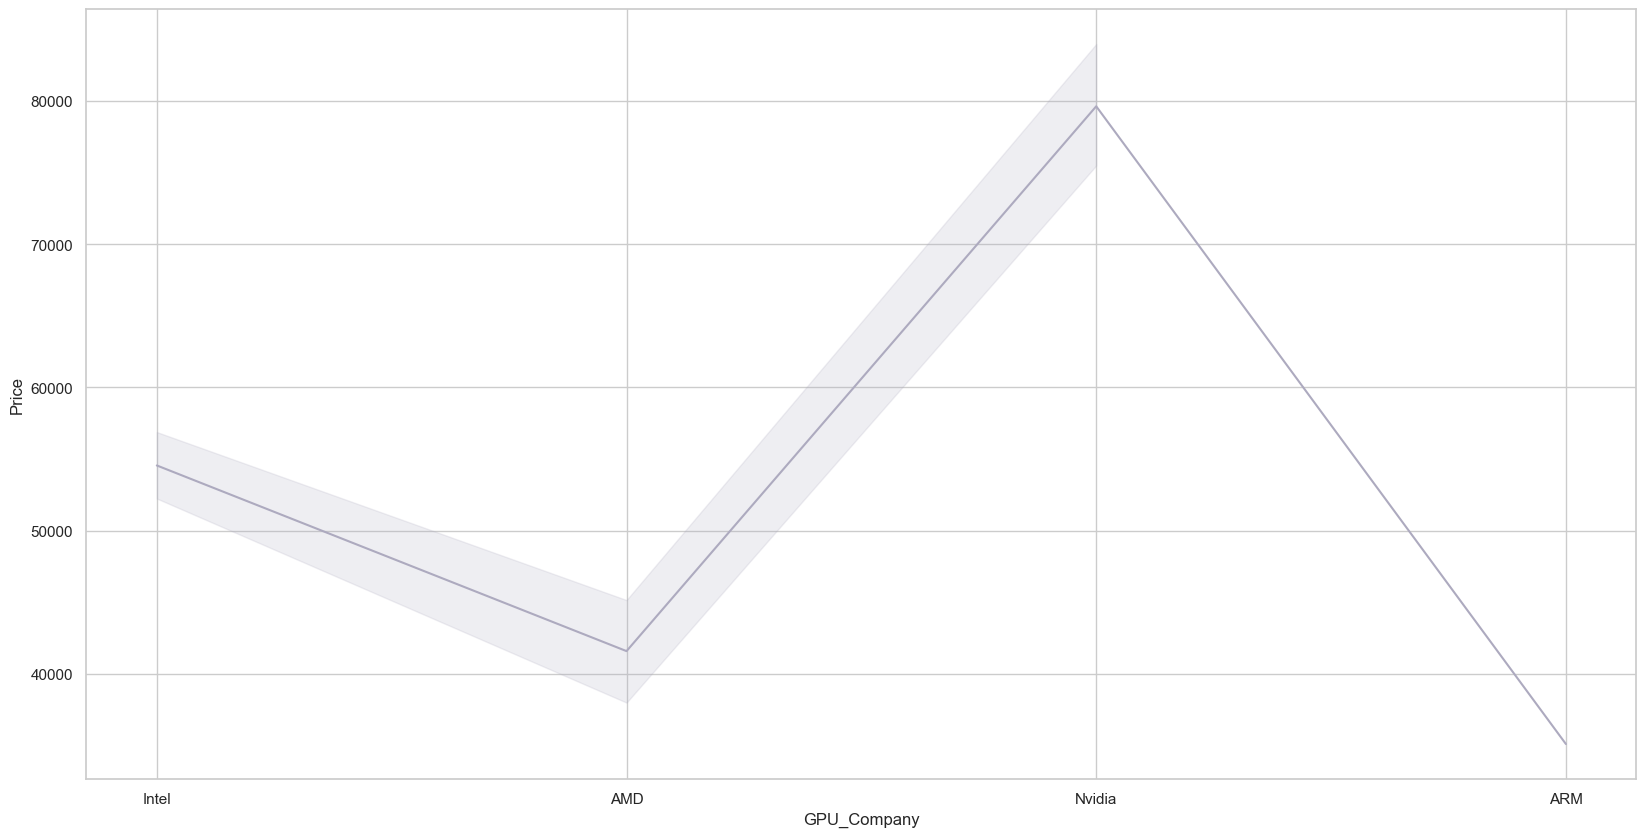

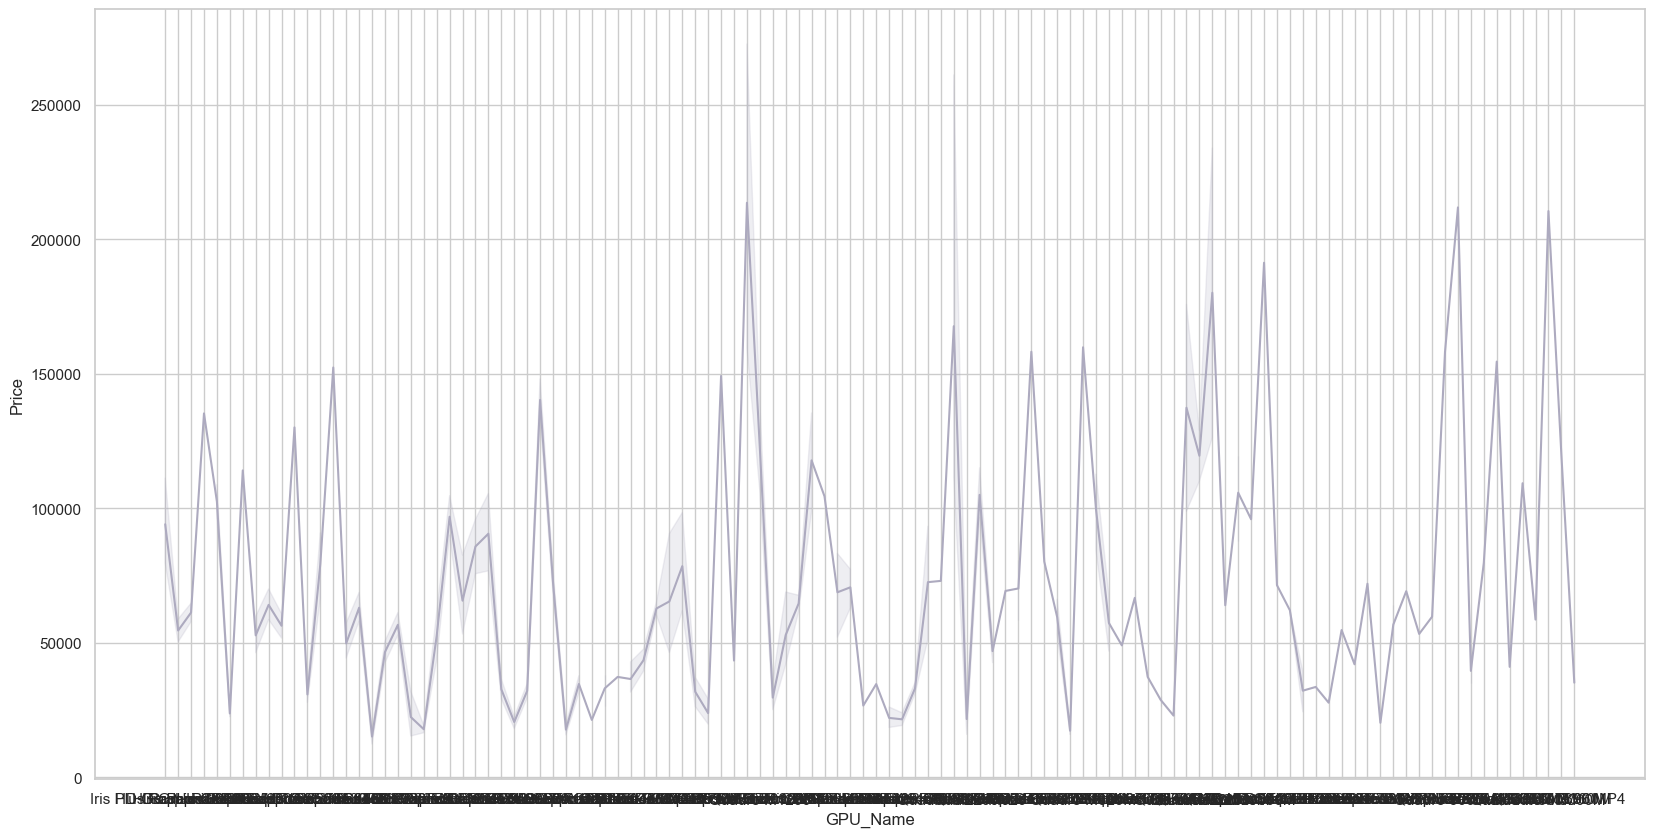

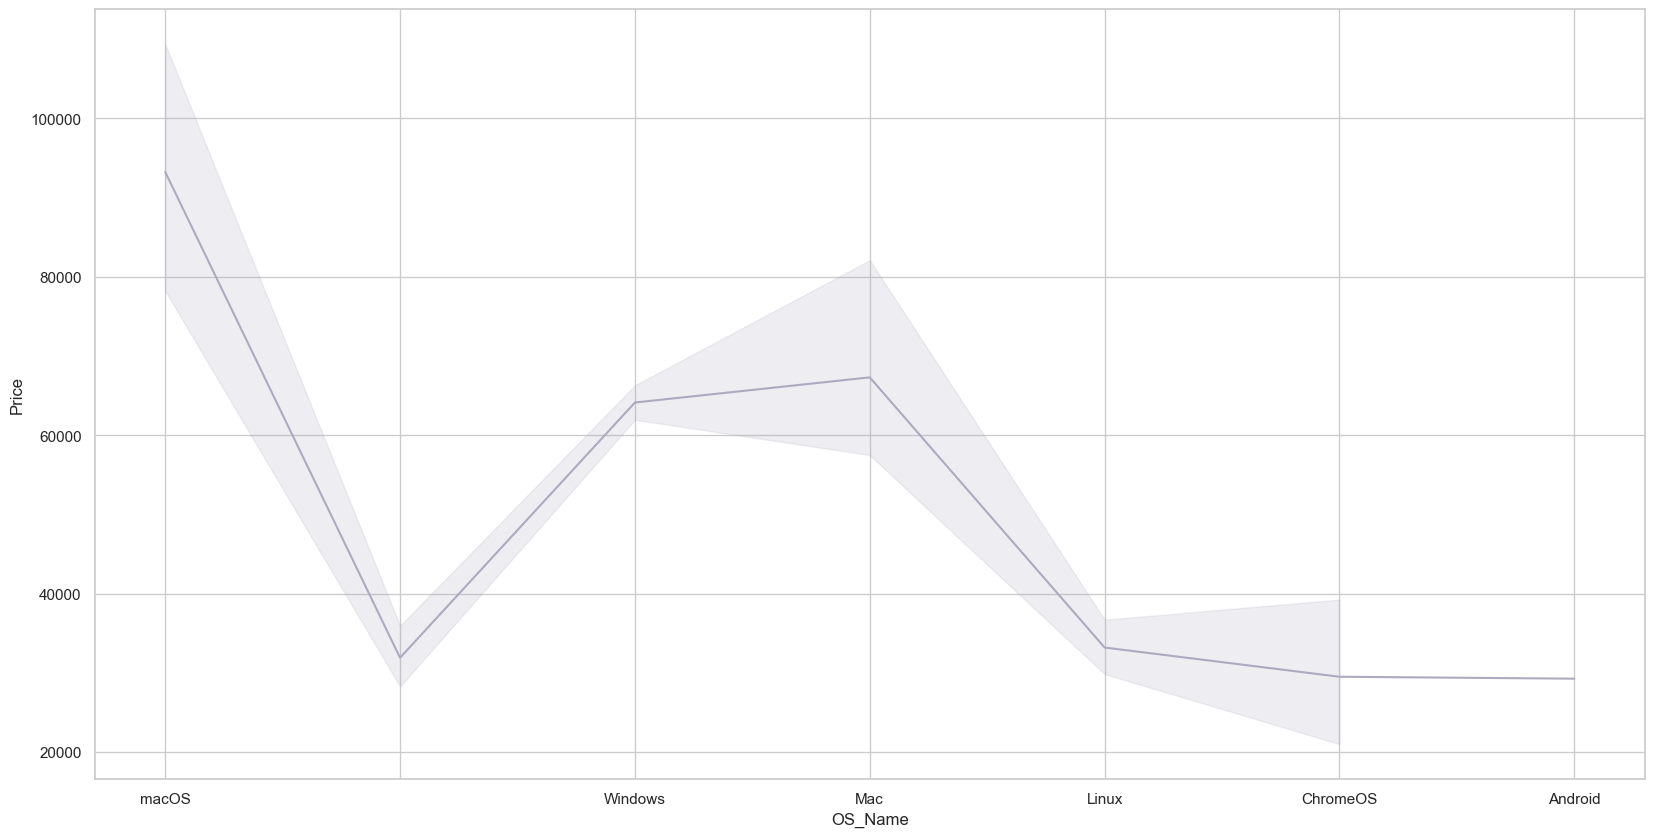

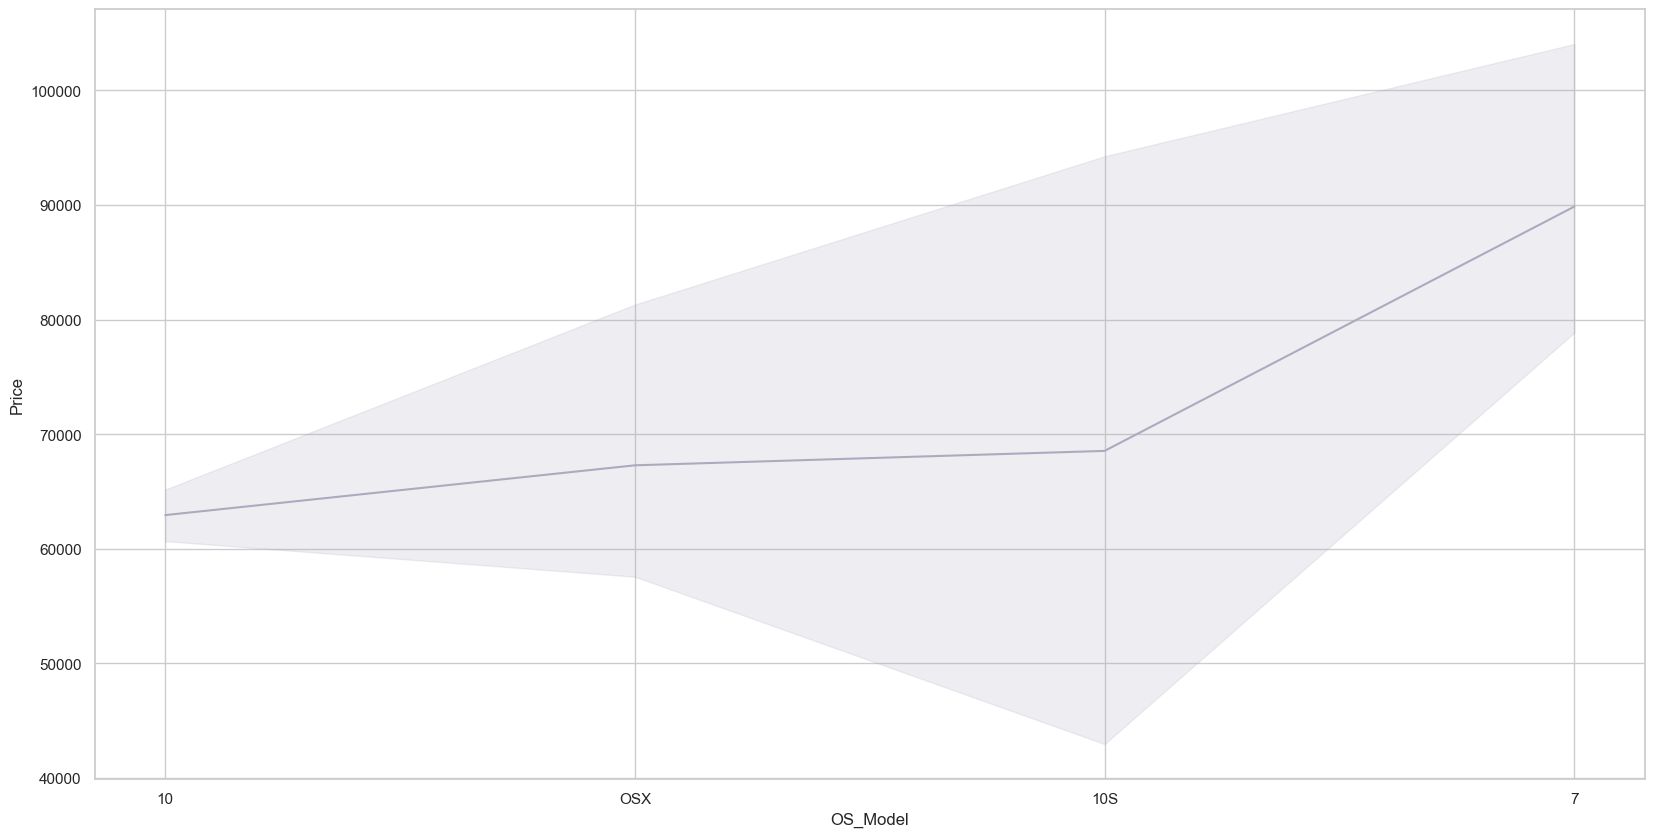

In [27]:
sns.set(style = "whitegrid")

for i in df.drop( columns = [ 'Price', 'Weight', 'CPU_Type', 'Memory1']):
    plt.figure(figsize=( 20 , 10 ))
    sns.lineplot( x = df[i].sort_values(), y = df.Price, color = '#ADAABF', markers = '*')
    plt.show()

In [28]:
le = LabelEncoder()

name = list(df.columns)
type = df.dtypes

for i in range(len(type)):
    if type[i] == 'object':
        le.fit_transform(df[name[i]])
        df[name[i]] = le.transform(df[name[i]])

df

C:\Users\Thinh\AppData\Local\Temp\ipykernel_15928\4168342975.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type[i] == 'object':
C:\Users\Thinh\AppData\Local\Temp\ipykernel_15928\4168342975.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type[i] == 'object':
C:\Users\Thinh\AppData\Local\Temp\ipykernel_15928\4168342975.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if type[i] == 'object':
C:\Users\Thinh\AppData\Lo

,Company,TypeName,Inches,Ram,Weight,Price,ScreenType,Resolution,CPU_Company,CPU_Type,CPU_Freq,Memory1,Memory2,GPU_Company,GPU_Name,OS_Name,OS_Model
0,1,4,8,9,39,71379.0,14,11,1,40,19,4,6,2,60,6,4
1,1,4,8,9,36,47896.0,0,2,1,40,14,2,6,2,53,6,4
2,7,3,15,9,75,30636.0,3,4,1,46,21,12,6,2,55,0,4
3,1,4,14,1,72,135195.0,14,13,1,54,23,20,6,0,80,6,4
4,1,4,8,9,39,96096.0,14,11,1,40,26,12,6,2,61,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,2,3,15,6,115,38379.0,0,1,1,55,21,17,6,3,7,5,0
1270,10,0,11,6,79,33993.0,11,4,1,55,21,4,6,2,49,5,0
1271,10,0,8,1,42,79867.0,13,14,1,55,21,20,6,2,49,5,0
1272,10,3,11,4,57,12201.0,0,1,1,20,13,21,6,2,42,5,0


array([[<Axes: title={'center': 'Company'}>,
        <Axes: title={'center': 'TypeName'}>,
        <Axes: title={'center': 'Inches'}>,
        <Axes: title={'center': 'Ram'}>],
       [<Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'ScreenType'}>,
        <Axes: title={'center': 'Resolution'}>],
       [<Axes: title={'center': 'CPU_Company'}>,
        <Axes: title={'center': 'CPU_Type'}>,
        <Axes: title={'center': 'CPU_Freq'}>,
        <Axes: title={'center': 'Memory1'}>],
       [<Axes: title={'center': 'Memory2'}>,
        <Axes: title={'center': 'GPU_Company'}>,
        <Axes: title={'center': 'GPU_Name'}>,
        <Axes: title={'center': 'OS_Name'}>],
       [<Axes: title={'center': 'OS_Model'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

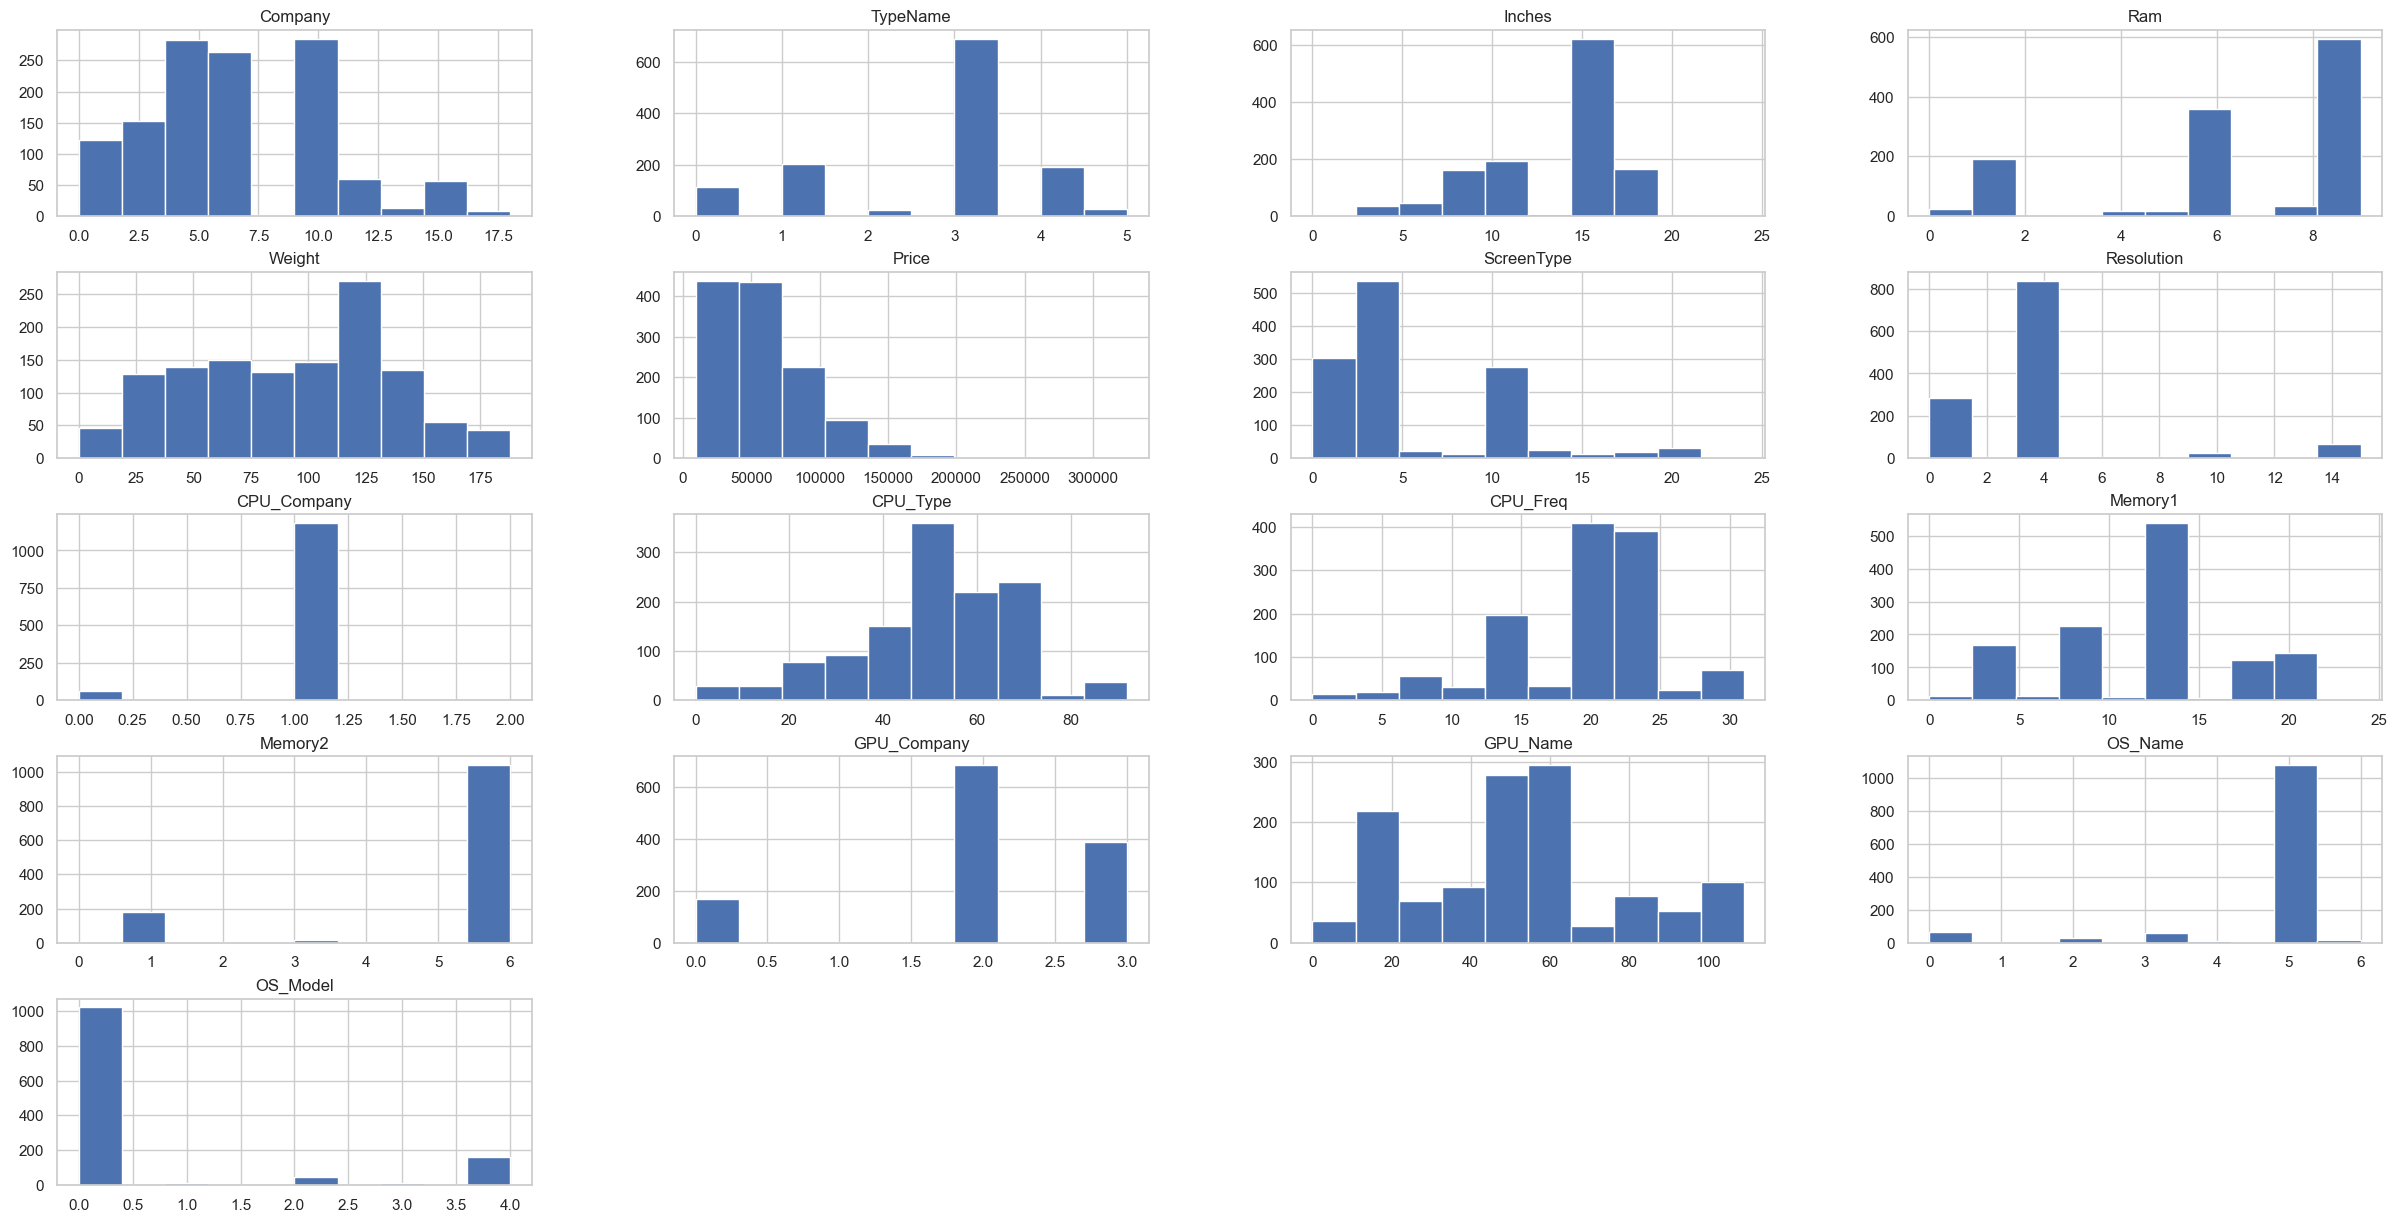

In [29]:
df.hist(figsize=(30, 15))

<Axes: >

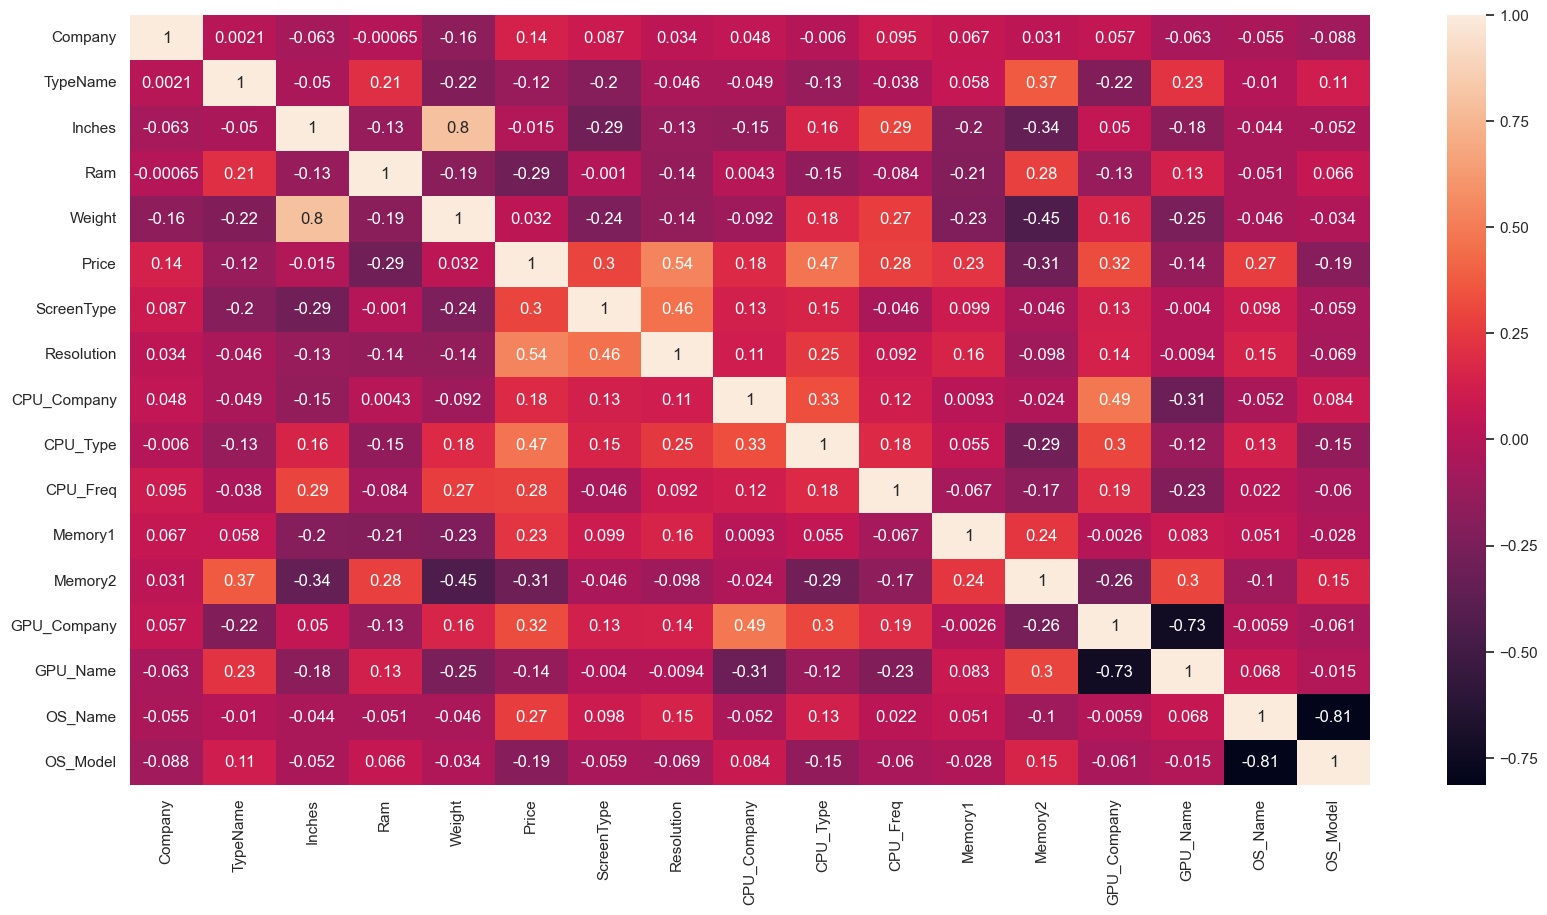

In [30]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)

In [31]:
# # từ bản tương quan có thể thấy rằng bằng thạc sĩ hoặc cử nhân có tương quang tương đương nhau nên có thểm drop 1 trong 2
df.drop('OS_Model', axis=1, inplace=True)
df.drop('GPU_Name', axis=1, inplace=True)
df.drop('Weight', axis=1, inplace=True)

df.head()

,Company,TypeName,Inches,Ram,Price,ScreenType,Resolution,CPU_Company,CPU_Type,CPU_Freq,Memory1,Memory2,GPU_Company,OS_Name
0,1,4,8,9,71379.0,14,11,1,40,19,4,6,2,6
1,1,4,8,9,47896.0,0,2,1,40,14,2,6,2,6
2,7,3,15,9,30636.0,3,4,1,46,21,12,6,2,0
3,1,4,14,1,135195.0,14,13,1,54,23,20,6,0,6
4,1,4,8,9,96096.0,14,11,1,40,26,12,6,2,6


<Axes: >

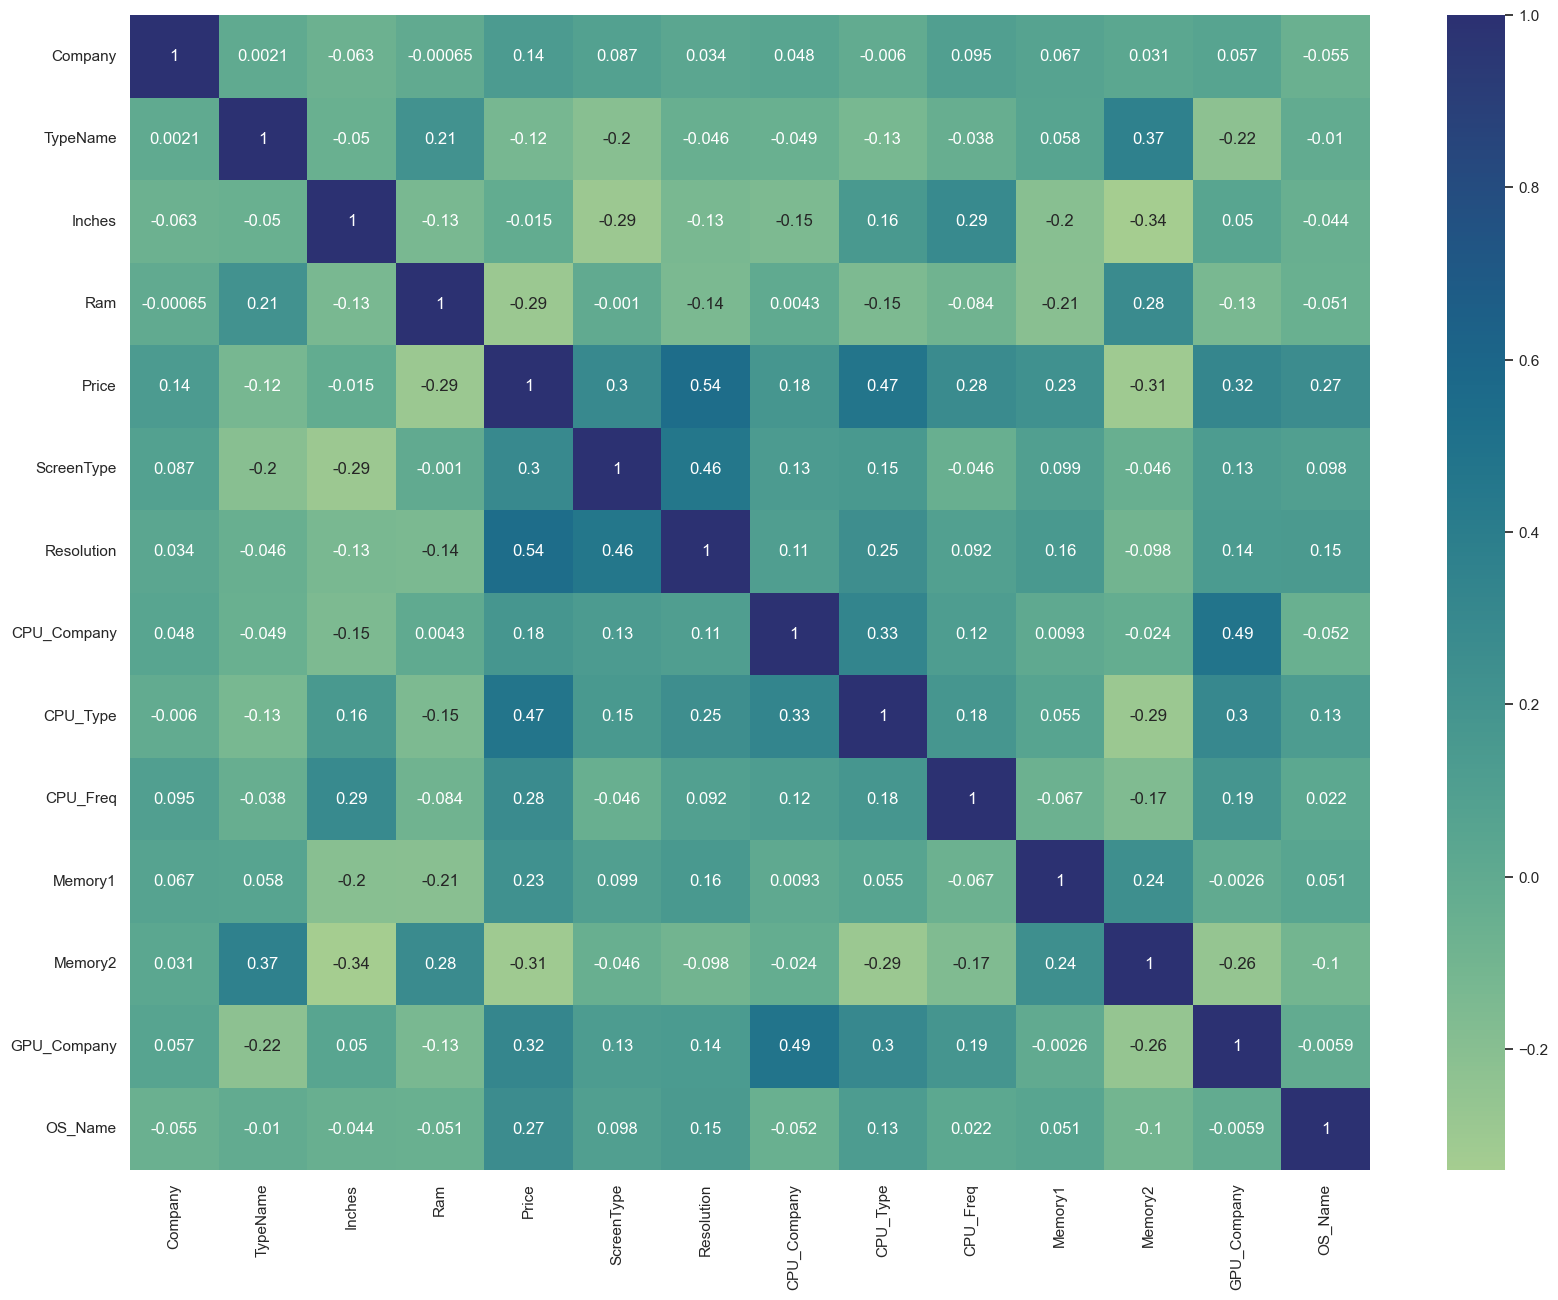

In [32]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True, cmap="crest")

### Tách data



In [33]:
X = df.drop('Price', axis=1)
y = df['Price']

In [34]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [35]:
X_scaled

array([[0.05555556, 0.8       , 0.33333333, ..., 1.        , 0.66666667,
        1.        ],
       [0.05555556, 0.8       , 0.33333333, ..., 1.        , 0.66666667,
        1.        ],
       [0.38888889, 0.6       , 0.625     , ..., 1.        , 0.66666667,
        0.        ],
       ...,
       [0.55555556, 0.        , 0.33333333, ..., 1.        , 0.66666667,
        0.83333333],
       [0.55555556, 0.6       , 0.45833333, ..., 1.        , 0.66666667,
        0.83333333],
       [0.38888889, 0.6       , 0.625     , ..., 1.        , 0.        ,
        0.83333333]])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=5, test_size=0.3)
y_train

1216    31861.0
1097    85195.0
681     22324.0
609     18595.0
296     52161.0
         ...   
76      27652.0
1170    36177.0
1025    83064.0
214     79867.0
889     20193.0
Name: Price, Length: 870, dtype: float64

## Phần 2: Ứng dụng các mô hình học máy cơ bản để giải quyết bài toán, bao gồm cả các mô hình thuộc Ensemble Learing;

### Các mô hình cơ bản

#### kNN

#### Linear Regression

#### Decision Tree

#### Naive Bayes

#### Support Vector Machine

#### Logistic Regression

### Essembled Model

In [37]:
# Định nghĩa danh sách các metric để đánh giá
scoring = {'mse': 'neg_mean_squared_error',
           'mae': 'neg_mean_absolute_error',
           'r2': 'r2'}

#### Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

gb = GradientBoostingRegressor()

# Áp dụng cross-validation và tính toán các metric
cv_results = cross_validate(gb, X, y, cv=5, scoring=scoring)

# Trích xuất kết quả từ cross-validation
gb_mse = -cv_results['test_mse']
gb_mae = -cv_results['test_mae']
gb_r2 = cv_results['test_r2']

print_metrics(gb_mse, gb_mae, gb_r2)


MSE scores: [2.50791662e+08 1.75290592e+08 2.99906931e+08 3.09396657e+08
 4.25692739e+08]
Mean MSE score: 292215716.21812075
MAE scores: [11929.51393246  9879.51841936 11369.56241904 12400.52140533
 12743.93548199]
Mean MAE score: 11664.610331636224
R2 scores: [0.79430076 0.84982576 0.81594826 0.79123617 0.69120276]
Mean R2 score: 0.7885027422690426


#### Adaboost

In [39]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor()

cv_results = cross_validate(ada, X_scaled, y, cv=5, scoring=scoring)

ada_mse = -cv_results['test_mse']
ada_mae = -cv_results['test_mae']
ada_r2 = cv_results['test_r2']

print_metrics(ada_mse, ada_mae, ada_r2)

MSE scores: [7.16901523e+08 5.46344753e+08 5.79520320e+08 4.83832280e+08
 6.51444712e+08]
Mean MSE score: 595608717.6239127
MAE scores: [23297.6378196  20179.52759567 19702.46408484 17831.5871815
 19869.27449213]
Mean MAE score: 20176.098234751484
R2 scores: [0.41199761 0.53193777 0.64435059 0.67353661 0.52744242]
Mean R2 score: 0.5578529989874907


#### Bagging

In [40]:
from sklearn.ensemble import BaggingRegressor

bg = BaggingRegressor()

cv_results = cross_validate(bg, X, y, cv=5, scoring=scoring)

# Trích xuất kết quả từ cross-validation
bg_mse = -cv_results['test_mse']
bg_mae = -cv_results['test_mae']
bg_r2 = cv_results['test_r2']

print_metrics(bg_mse, bg_mae, bg_r2)

MSE scores: [3.05486593e+08 2.53899310e+08 3.81163288e+08 3.93468029e+08
 4.27950312e+08]
Mean MSE score: 352393506.32474834
MAE scores: [12056.31232358 11345.65343633 12195.39370969 13420.52742526
 12112.36786242]
Mean MAE score: 12226.050951455065
R2 scores: [0.74944    0.78248043 0.76608154 0.73450944 0.68956512]
Mean R2 score: 0.7444153033677503


#### Random Forest

In [41]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

cv_results = cross_validate(rf, X, y, cv=5, scoring=scoring)

rf_mse = -cv_results['test_mse']
rf_mae = -cv_results['test_mae']
rf_r2 = cv_results['test_r2']

print_metrics(rf_mse, rf_mae, rf_r2)

MSE scores: [2.83026591e+08 1.99952784e+08 3.28001005e+08 3.73503094e+08
 4.20233927e+08]
Mean MSE score: 320943480.4861671
MAE scores: [11858.81595325 10350.76732174 11464.62605807 12876.4244394
 11954.96299159]
Mean MAE score: 11701.119352811711
R2 scores: [0.76786168 0.82869727 0.79870703 0.74798067 0.69516258]
Mean R2 score: 0.7676818476801145


#### Voting


In [42]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Khởi tạo các mô hình con
model1 = LinearRegression()
model2 = DecisionTreeRegressor()
model3 = SVR()

# Khởi tạo mô hình VotingRegressor với các mô hình con
vt = VotingRegressor([('lr', model1), ('dt', model2), ('svr', model3)])

cv_results = cross_validate(vt, X, y, cv=5, scoring=scoring)

vt_mse = -cv_results['test_mse']
vt_mae = -cv_results['test_mae']
vt_r2 = cv_results['test_r2']

print_metrics(vt_mse, vt_mae, vt_r2)

MSE scores: [4.32292786e+08 3.50398577e+08 6.16343337e+08 7.66552600e+08
 6.58511660e+08]
Mean MSE score: 564819792.0498863
MAE scores: [14447.98359927 14611.74498051 17055.05749859 18448.09879462
 17010.97567807]
Mean MAE score: 16314.772110211223
R2 scores: [0.6454336  0.69980797 0.62175244 0.48277251 0.52231606]
Mean R2 score: 0.5944165157438588


#### Stacking

In [43]:
from sklearn.ensemble import StackingRegressor

estimators = [('lr', model1), ('dt', model2), ('svr', model3)]

stacking = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
cv_results = cross_validate(stacking, X, y, cv=5, scoring=scoring)

st_mse = -cv_results['test_mse']
st_mae = -cv_results['test_mae']
st_r2 = cv_results['test_r2']

print_metrics(st_mse, st_mae, st_r2)

MSE scores: [3.44972764e+08 2.82391792e+08 4.95237375e+08 5.66746186e+08
 4.82643355e+08]
Mean MSE score: 434398294.4284533
MAE scores: [13678.80689965 12367.61542248 15065.73428929 16189.13965533
 13974.27654943]
Mean MAE score: 14255.114563233961
R2 scores: [0.71705345 0.75807046 0.69607471 0.61759087 0.64989082]
Mean R2 score: 0.6877360635680836


In [44]:
mse_values = {
        'GradientBoosting': gb_mse,
        'AdaBoost': ada_mse,
        'Bagging': bg_mse,
        'Random Forest': rf_mse,
        'Voting': vt_mse,
        'Stacking': st_mse
}

mae_values = {
        'GradientBoosting': gb_mae,
        'AdaBoost': ada_mae,
        'Bagging': bg_mae,
        'Random Forest': rf_mae,
        'Voting': rf_mae,
        'Stacking': st_mae
}

r2_values = {
        'GradientBoosting': gb_r2,
        'AdaBoost': ada_r2,
        'Bagging': bg_r2,
        'Random Forest': rf_r2,
        'Voting': vt_r2,
        'Stacking': st_r2
}


#### So sánh models bằng từng giá trị MSE, MAE, R2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


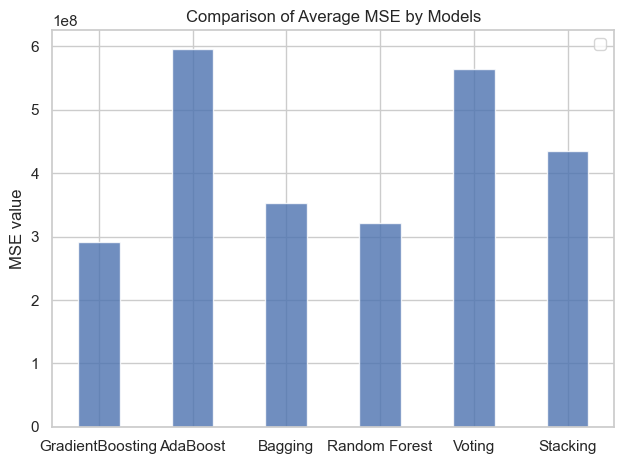

In [45]:
compare_metrics(mse_values, "MSE value", "Comparison of Average MSE by Models")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


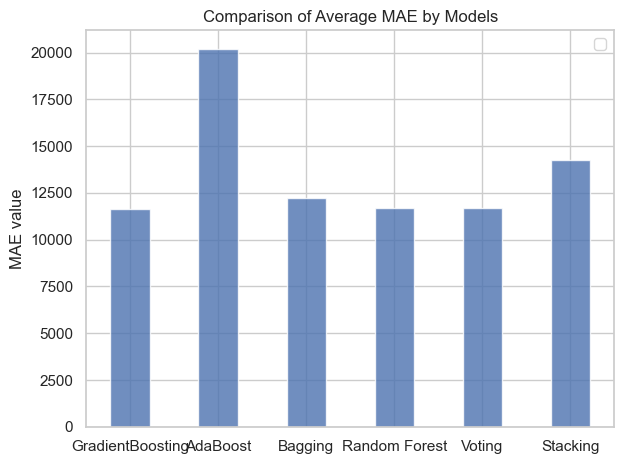

In [46]:
compare_metrics(mae_values, "MAE value", "Comparison of Average MAE by Models")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


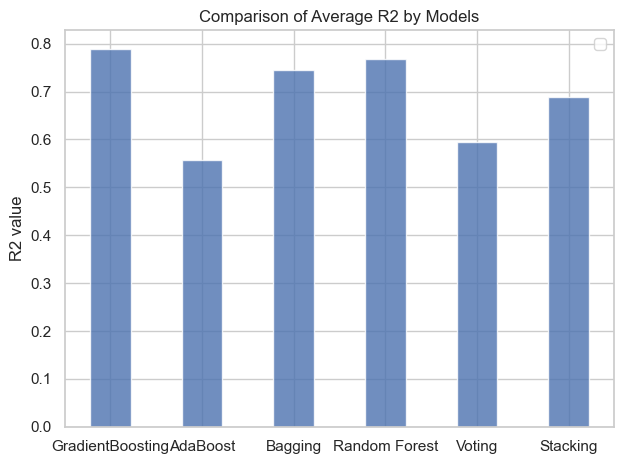

In [47]:
compare_metrics(r2_values, "R2 value", "Comparison of Average R2 by Models")

## Phần 3: 3	Sử dụng Feed Forward Neural Network và Reccurent Neural Network (hoặc mô thuộc loại này) để giải quyết bài toán;

### Feed Forward Neural Network:

Epoch 1/400
28/28 [==============================] - 1s 6ms/step - loss: 60375.4805 - val_loss: 61129.7148
Epoch 2/400
28/28 [==============================] - 0s 3ms/step - loss: 60352.3555 - val_loss: 61080.2930
Epoch 3/400
28/28 [==============================] - 0s 3ms/step - loss: 60257.8750 - val_loss: 60920.5508
Epoch 4/400
28/28 [==============================] - 0s 3ms/step - loss: 60005.1953 - val_loss: 60544.6914
Epoch 5/400
28/28 [==============================] - 0s 3ms/step - loss: 59468.2812 - val_loss: 59801.5352
Epoch 6/400
28/28 [==============================] - 0s 3ms/step - loss: 58476.1719 - val_loss: 58503.5703
Epoch 7/400
28/28 [==============================] - 0s 3ms/step - loss: 56813.6094 - val_loss: 56396.8789
Epoch 8/400
28/28 [==============================] - 0s 3ms/step - loss: 54189.7305 - val_loss: 53182.4648
Epoch 9/400
28/28 [==============================] - 0s 3ms/step - loss: 50295.6289 - val_loss: 48507.9023
Epoch 10/400
28/28 [=================

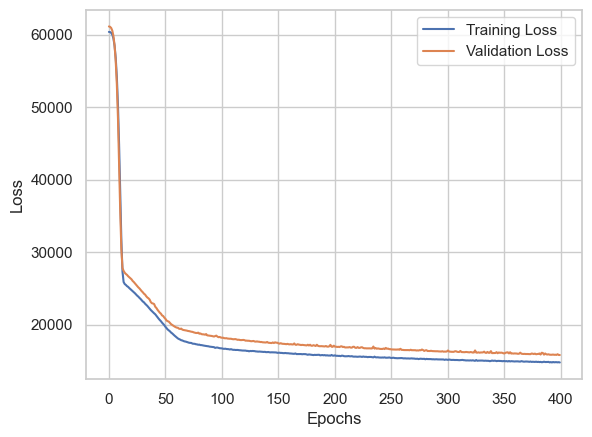

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                896       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8225 (32.13 KB)
Trainable params: 8225 (32.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [57]:
model_FFNW = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(13, )),
    tf.keras.layers.Dense(64, activation='relu', use_bias=True),
    tf.keras.layers.Dense(64, activation='relu', use_bias=True),
    tf.keras.layers.Dense(32, activation='relu', use_bias=True),
    tf.keras.layers.Dense(32, activation='relu', use_bias=True),
    tf.keras.layers.Dense(1, activation='linear')
])

model_FFNW.compile(loss='mean_absolute_error', optimizer='RMSprop')

history_FFNW = model_FFNW.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test))

plot_training_history(history_FFNW)

print(model_FFNW.summary())

In [54]:
print(model_FFNW.evaluate(X_test, y_test, verbose=0))

18276.1953125


### Recurrent Neural Network

In [50]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

array([[[0.        ],
        [0.6       ],
        [0.70833333],
        ...,
        [1.        ],
        [1.        ],
        [0.83333333]],

       [[0.61111111],
        [0.2       ],
        [0.70833333],
        ...,
        [1.        ],
        [1.        ],
        [0.83333333]],

       [[0.11111111],
        [0.6       ],
        [0.625     ],
        ...,
        [1.        ],
        [0.66666667],
        [0.83333333]],

       ...,

       [[0.38888889],
        [0.8       ],
        [0.25      ],
        ...,
        [1.        ],
        [0.66666667],
        [0.83333333]],

       [[0.44444444],
        [0.8       ],
        [0.29166667],
        ...,
        [1.        ],
        [0.66666667],
        [0.83333333]],

       [[0.55555556],
        [0.6       ],
        [0.70833333],
        ...,
        [1.        ],
        [0.        ],
        [0.83333333]]])

Epoch 1/300
28/28 [==============================] - 4s 29ms/step - loss: 60364.9141 - val_loss: 60868.0742
Epoch 2/300
28/28 [==============================] - 0s 11ms/step - loss: 55192.5039 - val_loss: 53893.1641
Epoch 3/300
28/28 [==============================] - 0s 11ms/step - loss: 51900.2812 - val_loss: 50942.7227
Epoch 4/300
28/28 [==============================] - 0s 11ms/step - loss: 47292.2539 - val_loss: 46355.0000
Epoch 5/300
28/28 [==============================] - 0s 11ms/step - loss: 42450.8320 - val_loss: 41405.8750
Epoch 6/300
28/28 [==============================] - 0s 11ms/step - loss: 39266.6914 - val_loss: 39498.9414
Epoch 7/300
28/28 [==============================] - 0s 11ms/step - loss: 37732.5742 - val_loss: 38629.2812
Epoch 8/300
28/28 [==============================] - 0s 11ms/step - loss: 37023.4961 - val_loss: 37832.3867
Epoch 9/300
28/28 [==============================] - 0s 11ms/step - loss: 35897.2891 - val_loss: 36542.4180
Epoch 10/300
28/28 [========

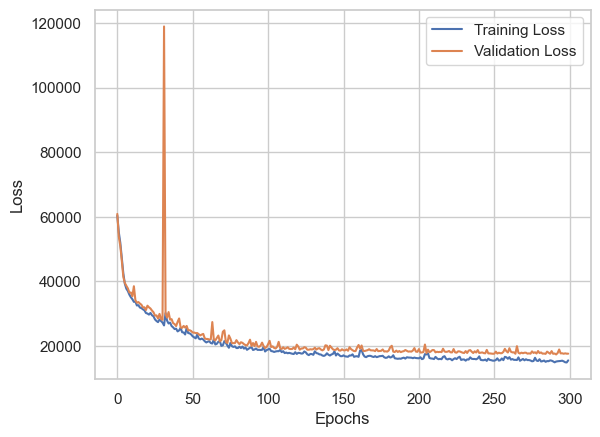

In [58]:

model_RNN = Sequential([
    tf.keras.layers.SimpleRNN(units = 64, activation='relu', return_sequences=True, input_shape= (X_train.shape[1],1)),
    tf.keras.layers.LSTM(units = 64, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(units = 64, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(units = 32, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(units = 32, activation='relu', return_sequences=True),
    tf.keras.layers.Dense(1, activation='linear')
    
])

model_RNN.compile(optimizer='adam', loss='mean_absolute_error')

history_RNN = model_RNN.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

plot_training_history(history_RNN)

In [59]:
print(model_RNN.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 13, 64)            4224      
                                                                 
 lstm_1 (LSTM)               (None, 13, 64)            33024     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 13, 64)            8256      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 13, 32)            3104      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 13, 32)            2080      
                                                                 
 dense_11 (Dense)            (None, 13, 1)             33        
                                                                 
Total params: 50721 (198.13 KB)
Trainable params: 5072

In [60]:
print(model_RNN.evaluate(X_test, y_test, verbose=0))

17624.388671875


## Phần 4: Áp dụng các kỹ thuật tránh Overfiting trên các mô hình của câu (2) và câu (3) để giải quyết bài toán;

## Phần 5: Sau khi huấn luyện xong mô hình thì muốn cải thiện độ chính xác, ta sẽ làm gì để giải quyết nó? Phân tích các trường hợp sai, đề ra giải pháp và thực hiện nó, sau đó đánh giá xem có cải tiến so với trước không.